In [1]:
its_jupyter_notebook = True

import pandas as pd
import os
import time
import numpy as np
import seaborn as sns
import pickle
import torch
from tqdm.notebook import tqdm
from pathlib import Path
import argparse
import math
from scipy import stats
import copy
import matplotlib.pyplot as plt
import sys
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, auc, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

sys.path.insert(0, '..')

from util.evaluation import load_paris_results, load_ricseq_splash_mario_results, map_signal_to_sigmoid_range, balance_df, plot_histogram_01, remove_outliers, log_func, load_res_and_tools, plot_all_model_auc, plot_all_model_auc, obtain_all_model_auc, obtain_all_model_auc_patches, obtain_subset_from_task, plot_results_of_all_models, obtain_sr_nosr, make_plot_kde_and_test_difference, calculate_correlations
from util.plot_utils import plot_results_based_on_treshold_for_all_models, plot_results_based_on_topbottom_for_all_models, plot_results_how_many_repeats_in_pred_pos_for_all_models, plot_metric_confidence_for_all_models, plot_tnr_based_on_distance_for_all_models, plot_confidence_based_on_distance_for_all_models, plot_tnr_for_all_models, quantile_bins, plot_features_vs_risearch2_confidence, plot_heatmap
# %load_ext autoreload
# %autoreload 2

from config import *
from models.nt_classifier import build as build_model 
if its_jupyter_notebook:
    sys.argv = [''] #Remove this if it's not a jupyter notebook!
    
external_dataset_dir = os.path.join(dataset_files_dir, 'external_dataset', '500_test_tables')

<class 'transformers.tokenization_dna.DNATokenizer'>


In [2]:
datasets = ['paris', 'ricseq', 'splash', 'mario']
tools = ['priblast', 'RNAplex', 'rnacofold', 'assa', 'risearch2', 'RNAhybrid', 'RNAup'] #['priblast', 'risearch2'] #['priblast', 'RNAup', 'RNAplex', 'RNAhybrid', 'rnacofold', 'risearch2', 'assa']
energy_columns = tools + ['E_norm']

#ARGS for paris
SPECIE_PARIS = 'human'
PARIS_HQ = False
PARIS_HQ_THRESHOLD = 35
MIN_N_READS_RICSEQ = 2
RICSEQ_HQ = False

RICSEQ_TEST = False
SPLASH_TEST = True

#ARGS for splash, ricseq, mario


args_datasets = {'paris':
                 {'only_test' : np.nan, #uneuseful for paris
                  'exclude_train_genes' : np.nan, #uneuseful for paris
                  'exclude_paris_genes' : np.nan, #uneuseful for paris
                  'exclude_paris_couples' : np.nan, #uneuseful for paris
                  'filter_hq_ricseq' : np.nan, #uneuseful for paris
                  'MIN_N_READS_RICSEQ' : np.nan, #uneuseful for paris
                  'SPECIE_PARIS' : SPECIE_PARIS,
                  'PARIS_HQ':PARIS_HQ,
                  'PARIS_HQ_THRESHOLD':PARIS_HQ_THRESHOLD,
                 }, 
                 'ricseq': 
                 {'only_test' : RICSEQ_TEST,
                  'exclude_train_genes' : False,
                  'exclude_paris_genes' : False,
                  'exclude_paris_couples' : True,
                  'filter_hq_ricseq' : RICSEQ_HQ,
                  'MIN_N_READS_RICSEQ' : MIN_N_READS_RICSEQ,
                  'SPECIE_PARIS' : np.nan, #uneuseful for ricseq
                  'PARIS_HQ':np.nan, #uneuseful for ricseq
                  'PARIS_HQ_THRESHOLD':np.nan, #uneuseful for ricseq
                 },
                 'splash': 
                 {'only_test' : SPLASH_TEST,
                  'exclude_train_genes' : False,
                  'exclude_paris_genes' : False,
                  'exclude_paris_couples' : True,
                  'filter_hq_ricseq' : False, #uneuseful for splash
                  'MIN_N_READS_RICSEQ' : np.nan, #uneuseful for splash
                  'SPECIE_PARIS' : np.nan, #uneuseful for splash
                  'PARIS_HQ':np.nan, #uneuseful for splash
                  'PARIS_HQ_THRESHOLD':np.nan, #uneuseful for splash
                 },
                'mario': 
                 {'only_test' : False,
                  'exclude_train_genes' : False,
                  'exclude_paris_genes' : False,
                  'exclude_paris_couples' : True,
                  'filter_hq_ricseq' : False, #uneuseful for mario
                  'MIN_N_READS_RICSEQ' : np.nan,  #uneuseful for mario
                  'SPECIE_PARIS' : np.nan, #uneuseful for mario
                  'PARIS_HQ':np.nan, #uneuseful for mario
                  'PARIS_HQ_THRESHOLD':np.nan, #uneuseful for mario
                 },
}

args_datasets['test'] = args_datasets['paris'] #sometimes I want to call it 'test'

In [3]:
# nt_models = ['all_modelarch2_wrongSN_easypretrain11_paristfinetuningSPLASHval0039parisHQSPLASHval0054_okSN_splashPARISFINETUNINGtrainhqRICSEQval0060_NOWENHNokSN_splashPARISFINETUNINGtrainhqRICSEQval0083',
#              'all_modelarch2_wrongSN_easypretrain11_paristfinetuningSPLASHval0039_NOWENHNokSN_PARISFINETUNINGtrainhqSPLASHval0043', 
#              'all_modelarch2_wrongSN_easypretrain11_paristfinetuningSPLASHval0039parisHQSPLASHval0054_okSN_PARISFINETUNINGtrainhqRICSEQval0055_NOWENHNokSN_parisfinetuningTRAINHQhumanRICSEQval0079',
#             ]
nt_models = ['all_modelarch2_wrongSN_easypretrain11_paristfinetuningSPLASHval0039parisHQSPLASHval0054_okSN_splashPARISFINETUNINGtrainhqRICSEQval0060_NOWENHNokSN_splashPARISFINETUNINGtrainhqRICSEQval0083',]

In [4]:
checkpoint_dir = os.path.join(ROOT_DIR, 'checkpoints', nt_models[0]) 
#'less_samples_in_train',
#all_modelarch2_easypretrain3_paristfinetuning14_ricseq23_splash151
# all_modelarch2_easypretrain3_paristfinetuning14_ricseq23_splash151_trainall0198

# Model comparison

In [5]:
with open(LR_MAPPING_PATH, 'rb') as file:
    logistic_regression_models = pickle.load(file)

In [6]:
from util.evaluation import *

In [30]:
def load_res_and_tools(external_dataset_dir, checkpoint_dir, tools, dataset, how, only_test, exclude_train_genes, exclude_paris_genes, exclude_paris_couples, filter_hq_ricseq, MIN_N_READS_RICSEQ, specie_paris, paris_hq, paris_hq_threshold):
    
    if type(checkpoint_dir) == str:
        checkpoint_dir = [checkpoint_dir]
    else:
        assert type(checkpoint_dir) == list
        assert type(checkpoint_dir[0]) == str

    if dataset == 'paris':
        
        test500 = pd.read_csv(os.path.join(metadata_dir, f'test500.csv'))
        test500['distance_from_site'] = ( (test500['distance_x'] ** 2) + (test500['distance_y']** 2) )**(0.5) #pitagora
        test500['distance_from_site_embedding'] = ( (test500['distance_embedding_x'] ** 2) + (test500['distance_embedding_y']** 2) )**(0.5) #pitagora
        df_nt = pd.read_csv(os.path.join(metadata_dir, f'df_nt_HQ.csv'))
        assert test500.shape[0] == df_nt[['couples', 'interacting']].merge(test500, on = 'couples').shape[0]
        test500 = df_nt[['couples', 'interacting']].merge(test500, on = 'couples').reset_index(drop = True)
        
        for i in range(len(checkpoint_dir)):
            r = load_paris_results(checkpoint_dir[i], test500, df_nt, 'test', specie_paris)
            if paris_hq:
                r = filter_hq_data_by_interaction_length(r, test500, paris_hq_threshold)
                
            if i == 0:
                res = r.copy()
            else:
                r = r.rename({'probability':f'nt{i}'}, axis = 1)
                res = pd.concat([res, r[f'nt{i}']], axis = 1)
    else:
        test500 = pd.read_csv(os.path.join(metadata_dir, f'{how}500.csv'))
        test500['distance_from_site'] = ( (test500['distance_x'] ** 2) + (test500['distance_y']** 2) )**(0.5) #pitagora
        test500['distance_from_site_embedding'] = ( (test500['distance_embedding_x'] ** 2) + (test500['distance_embedding_y']** 2) )**(0.5) #pitagora
        df_nt = pd.read_csv(os.path.join(metadata_dir, f'df_nt_{how}.csv'))
        assert df_nt[['couples', 'interacting']].drop_duplicates().shape[0] == df_nt.shape[0]
        test500 = df_nt[['couples', 'interacting']].merge(test500, on = 'couples')
        
        for i in range(len(checkpoint_dir)):
            r = load_ricseq_splash_mario_results(checkpoint_dir[i], test500, df_nt, how, only_test, exclude_train_genes, exclude_paris_genes, exclude_paris_couples, filter_hq_ricseq, MIN_N_READS_RICSEQ)
            if i == 0:
                res = r.copy()
            else:
                r = r.rename({'probability':f'nt{i}'}, axis = 1)
                res = pd.concat([res, r[f'nt{i}']], axis = 1)
    
    assert (res['ground_truth'] == res['interacting'].astype(int)).all()
    
    
    for tool_name in tools:
        tool = pd.read_csv(os.path.join(external_dataset_dir, f'{tool_name}_{how}500.csv'), sep = ',').fillna(0)
        tool['value'] = tool['value'].astype(float)
        assert (tool.minimum == True).all()
        res = res.merge(tool[['value', 'couples']].rename({'couples':'id_sample', 'value':tool_name}, axis =1), on = 'id_sample', how = 'left').fillna(0)

    
    #mi serve solo per il merge, poi le elimino queste colonne
    if dataset == 'splash':
        df_nt['simple_repeats'] = np.nan
        df_nt['sine_alu'] = np.nan 
        df_nt['low_complex'] = np.nan 
        df_nt['n_reads'] = np.nan 
    
    #now we merge with ENHN500
    testenhn500 = pd.read_csv(os.path.join(metadata_dir, f'{how}ENHN500.csv'))
    testenhn500['distance_from_site'] = ( (testenhn500['distance_x'] ** 2) + (testenhn500['distance_y']** 2) )**(0.5) #pitagora
    testenhn500['distance_from_site_embedding'] = ( (testenhn500['distance_embedding_x'] ** 2) + (testenhn500['distance_embedding_y']** 2) )**(0.5) #pitagora
    testenhn500 = df_nt[['couples', 'where', 'where_x1', 'where_y1', 'simple_repeats', 'sine_alu', 'low_complex']].merge(testenhn500, on = 'couples')
    
    for i in range(len(checkpoint_dir)):
        r = pd.read_csv(os.path.join(checkpoint_dir[i], f'{how}ENHN_results500.csv')).drop('policy', axis = 1)
        print(r.ground_truth.value_counts())
        print(r.policy.value_counts())
        r['ground_truth'] = 0
        r['interacting'] = False
        if i == 0:
            enhn = r.copy()
        else:
            r = r.rename({'probability':f'nt{i}'}, axis = 1)
            enhn = pd.concat([enhn, r[f'nt{i}']], axis = 1)
    
    if dataset == 'ricseq':
        #aggiungi n_reads a testenhn500, quindi a enhn (visto che poi lo mergio con testenhn500)
        to_merge = res[['id_sample', 'n_reads']].rename({'id_sample':'couples'}, axis = 1).drop_duplicates().reset_index(drop=True)
        assert len(set(to_merge.couples)) == to_merge.shape[0]
        testenhn500 = testenhn500.merge(to_merge)
                
           
    #tengo solo le couples di res, perche escludo quelle che erano tipo nel training di paris, oppure solo paris human, oppure quelle < n_reads_ricseq, ecc... 
    enhn = enhn[enhn.couples.isin(res.couples)].reset_index(drop = True)
    
    #policy tengo quello di testenhn500, che sono hn, en
    enhn = enhn.merge(testenhn500.drop(['g1', 'g2'], axis = 1).rename({'couples':'id_sample'}, axis = 1), on = 'id_sample').reset_index(drop = True)

    enhnintarna = load_intarnaENHN500(how)
    enhn = enhn.merge(enhnintarna[['E','E_norm', 'couples']].rename({'couples':'id_sample'}, axis =1), on = 'id_sample', how = 'left').fillna(0)
    enhn['original_area'] = enhn.original_length1 * enhn.original_length2    

    how = how + 'ENHN'
    for tool_name in tools:
        tool = pd.read_csv(os.path.join(external_dataset_dir, f'{tool_name}_{how}500.csv'), sep = ',').fillna(0)
        tool['value'] = tool['value'].astype(float)
        assert (tool.minimum == True).all()
        enhn = enhn.merge(tool[['value', 'couples']].rename({'couples':'id_sample', 'value':tool_name}, axis =1), on = 'id_sample', how = 'left')

    # tolgo 'E_norm_conf', 'ensemble_score'
    res = res.filter(list(enhn.columns), axis = 1)
    
    res = pd.concat([res, enhn], axis = 0).reset_index(drop=True)
    
    res = res.drop(['Unnamed: 0', 'simple_repeats', 'sine_alu', 'low_complex'], axis = 1)
    res['dataset'] = dataset
    
    assert res[res.ground_truth.isna()].shape[0] == res[res.interacting.isna()].shape[0] == 0
    assert (res['ground_truth'] == res['interacting'].astype(int)).all()
    
    return res


def load_test_set_df(external_dataset_dir, checkpoint_dir, tools, dataset, args_datasets):
    
    assert dataset in ['psoralen', 'paris', 'splash', 'mario', 'ricseq']

    if (dataset == 'psoralen'):
        
        dataset, how = 'paris',  'test'
        paris = load_res_and_tools(external_dataset_dir, checkpoint_dir, tools, dataset, how, 
                                   args_datasets[how]['only_test'], 
                                   args_datasets[how]['exclude_train_genes'], 
                                   args_datasets[how]['exclude_paris_genes'], 
                                   args_datasets[how]['exclude_paris_couples'],
                                   args_datasets[how]['filter_hq_ricseq'], 
                                   args_datasets[how]['MIN_N_READS_RICSEQ'], 
                                   args_datasets[how]['SPECIE_PARIS'],
                                   args_datasets[how]['PARIS_HQ'],
                                   args_datasets[how]['PARIS_HQ_THRESHOLD'],)
        
        dataset, how = 'splash', 'splash'
        splash = load_res_and_tools(external_dataset_dir, checkpoint_dir, tools, dataset, how, 
                                   args_datasets[how]['only_test'], 
                                   args_datasets[how]['exclude_train_genes'], 
                                   args_datasets[how]['exclude_paris_genes'], 
                                   args_datasets[how]['exclude_paris_couples'],
                                   args_datasets[how]['filter_hq_ricseq'], 
                                   args_datasets[how]['MIN_N_READS_RICSEQ'], 
                                   args_datasets[how]['SPECIE_PARIS'],
                                   args_datasets[how]['PARIS_HQ'],
                                   args_datasets[how]['PARIS_HQ_THRESHOLD'],)
                  
        assert set(paris.columns) == set(splash.columns)
        res = pd.concat([paris, splash], axis = 0).reset_index(drop=True)
    
    else: 
        how = dataset if dataset != 'paris' else 'test'
        res = load_res_and_tools(external_dataset_dir, checkpoint_dir, tools, dataset, how, 
                                   args_datasets[how]['only_test'], 
                                   args_datasets[how]['exclude_train_genes'], 
                                   args_datasets[how]['exclude_paris_genes'], 
                                   args_datasets[how]['exclude_paris_couples'],
                                   args_datasets[how]['filter_hq_ricseq'], 
                                   args_datasets[how]['MIN_N_READS_RICSEQ'], 
                                   args_datasets[how]['SPECIE_PARIS'],
                                   args_datasets[how]['PARIS_HQ'],
                                   args_datasets[how]['PARIS_HQ_THRESHOLD'],)
                  
    return res


def plot_sr_distributions(df_sr, label_x, figsize = (16, 8)):

    # Create the violin plot without the inner box plot
    plt.figure(figsize=figsize)
    ax = sns.violinplot(x='Model', y='Normalized Score', hue='Category', data=df_sr, split=True, palette=['#FF9999', '#99FF99'], inner=None)

    # Add the mean points with custom horizontal lines
    mean_line_length = 0.3  # Adjust this value to control the length of the horizontal lines

    # Calculate means
    mean_points = df_sr.groupby(['Model', 'Category'])['Normalized Score'].mean().reset_index()

    # Get the positions of each category for plotting
    positions = {category: idx for idx, category in enumerate(df_sr['Model'].unique())}

    # Plot mean lines manually
    for i, model in enumerate(mean_points['Model'].unique()):
        for j, category in enumerate(mean_points['Category'].unique()):
            mean_val = mean_points[(mean_points['Model'] == model) & (mean_points['Category'] == category)]['Normalized Score'].values[0]
            pos = positions[model]
            # Add offset for split violin
            if category == label_x:
                pos -= mean_line_length / 2
            else:
                pos += mean_line_length / 2
            plt.plot([pos - mean_line_length / 2, pos + mean_line_length / 2], [mean_val, mean_val], color=['#A26565', '#568E56'][j], lw=2)

    # Adjust the legend to prevent duplication
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles[:2], labels[:2], title='Category')

    plt.title('Violin Plot with Two Distributions per Category')
    plt.show()
    
def obtain_epsn_ephnen_from_res(res):
    easypos_smartneg = res[(res.policy.isin(['easypos', 'smartneg']))].reset_index(drop = True)
    ephnen = res[
        ((res.distance_from_site_embedding > 0)&(res.policy.isin(['hardneg', 'easyneg']))) |
        (res.policy == 'easypos')
    ].reset_index(drop = True)
    enhn500 = res[(res.distance_from_site_embedding == 0)&(res.policy.isin(['easypos', 'hardneg', 'easyneg']))].reset_index(drop = True)
    return easypos_smartneg, ephnen, enhn500

### Do the model correlate in their scores?

# excluded couples:  12
DATASET: psoralen


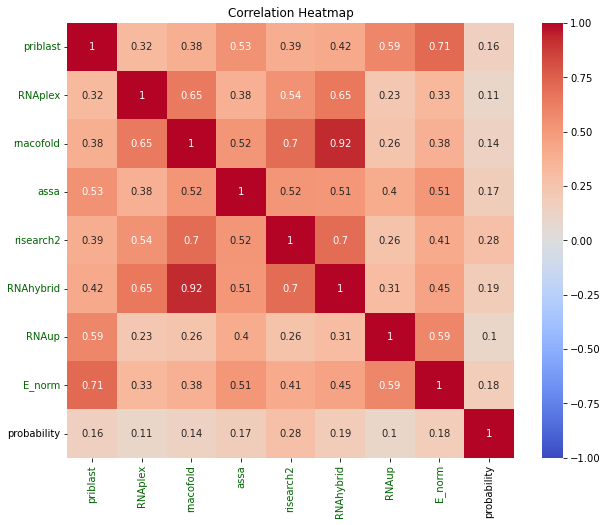

# excluded couples:  234
DATASET: ricseq


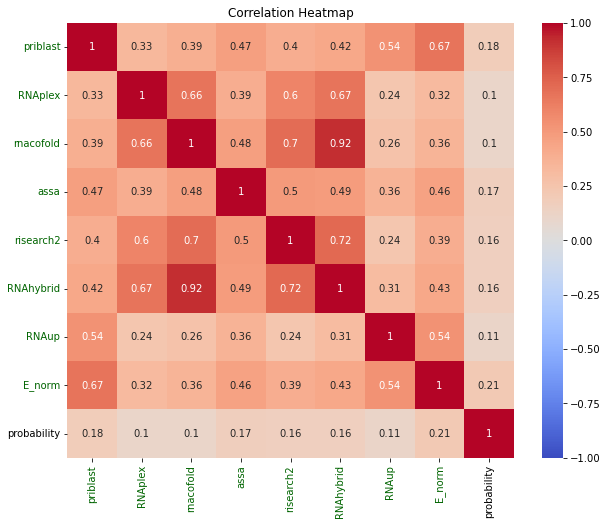

# excluded couples:  4
DATASET: mario


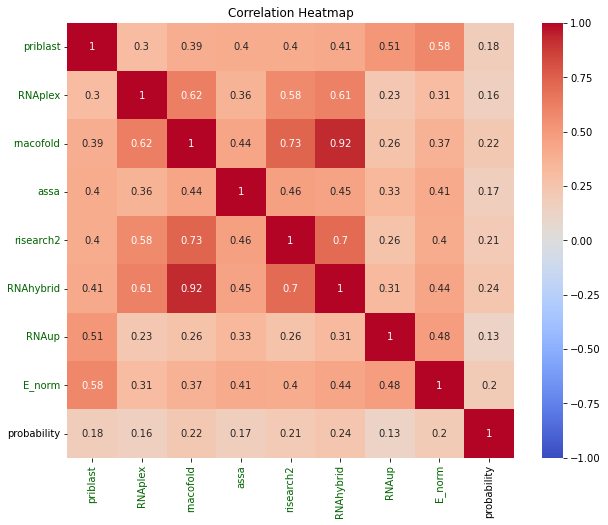

In [10]:
method='spearman' # 'pearson', 'spearman', 'kendall', 'mutual_info'
plot_each_correlation = False

for dataset in ['psoralen', 'ricseq', 'mario']:
    res = load_test_set_df(external_dataset_dir, checkpoint_dir, tools, dataset, args_datasets)

    for model_column in energy_columns:
        res[model_column] = - res[model_column] # make energy column positives, such that the correlations will be positives as well


    ep = res[res.policy == 'easypos']
    hn = res[res.policy == 'hardneg'].sample(ep.shape[0]//4)
    en = res[res.policy == 'easyneg'].sample(ep.shape[0]//4)
    sn = res[res.policy == 'smartneg'].sample(ep.shape[0]//4)

    res_for_corr = pd.concat([ep, en, hn, sn], axis = 0).reset_index(drop = True)
    
    print(f'DATASET: {dataset}')
    
    correlations = calculate_correlations([res_for_corr[i] for i in energy_columns + ['probability']], method=method, plot=plot_each_correlation)
    plot_heatmap(correlations, highlight_labels = energy_columns, method = method)

### AUC

In [12]:
plot_auc = False

dfs = []
for dataset in ['psoralen', 'ricseq', 'mario']:
    
    res = load_test_set_df(external_dataset_dir, checkpoint_dir, tools, dataset, args_datasets)
    
    easypos_smartneg, ephnen, enhn500 = obtain_epsn_ephnen_from_res(res) 
    
    dfs.append(obtain_all_model_auc(easypos_smartneg, tools).rename({'auc': f'auc_EPSN_{dataset}'}, axis = 1))
    
    dfs.append(obtain_all_model_auc_patches(res, tools).rename({'auc': f'auc_EPENHN_{dataset}'}, axis = 1))
    
    
    if plot_auc:
        print(f'DATASET: {dataset}')
        print('easypos_smartneg')
        plot_all_model_auc(easypos_smartneg, tools)
        print('ephnen')
        plot_all_model_auc(ephnen, tools)
        print('enhn500')
        plot_all_model_auc(enhn500, tools)
        print('\n\n')
        
df_auc = pd.concat(dfs, axis = 1)
df_auc = df_auc.loc[:,~df_auc.columns.duplicated()].copy()

# excluded couples:  12
# excluded couples:  234
# excluded couples:  4


In [13]:
df_auc

model_name  auc_EPSN_psoralen  auc_EPENHN_psoralen  auc_EPSN_ricseq  \
0         NT               0.59                 0.78             0.56   
1    INTARNA               0.53                 0.57             0.54   
2   priblast               0.53                 0.56             0.54   
3    RNAplex               0.51                 0.50             0.50   
4  rnacofold               0.51                 0.54             0.49   
5       assa               0.53                 0.55             0.53   
6  risearch2               0.56                 0.58             0.54   
7  RNAhybrid               0.52                 0.56             0.50   
8      RNAup               0.52                 0.55             0.53   

   auc_EPENHN_ricseq  auc_EPSN_mario  auc_EPENHN_mario  
0               0.75            0.49              0.72  
1               0.57            0.48              0.54  
2               0.57            0.48              0.54  
3               0.50            0.50              0.57  
4               0.52            0.48              0.64  
5               0.54            0.48              0.53  
6               0.55            0.48              0.58  
7               0.55            0.48              0.64  
8               0.55            0.50              0.54

# TODO: CREA subset paris per script inferenza

Quando faccio:

print(r.ground_truth.value_counts())

Sembra che r.ground_truth abbia sia 0 che 1. come mai? dovrebbero in teoria avere solo 0, controlla perche!!!!!!!

In [31]:
res = load_test_set_df(external_dataset_dir, checkpoint_dir, tools, 'paris', args_datasets)

1    7057
0    6970
Name: ground_truth, dtype: int64


AttributeError: 'DataFrame' object has no attribute 'policy'

In [14]:
#res = load_test_set_df(external_dataset_dir, checkpoint_dir, tools, 'paris', args_datasets)

# excluded couples:  4


### Repeats enrichment

In [15]:
#analysis args
feature_to_search = 'Simple_repeat'


full_overlap = False
if full_overlap:
    suffix = 'full_'
else:
    suffix = ''
    
both_sr_condition = True

In [16]:
#kde plot args
figsize_kde = (7, 4)

#treshold plot args
figsize_treshold = (17,9)
MIN_PERC = 1
n_values = 12
size_multiplier = 0
n_run_undersampling = 15
list_of_metrics = ['precision_recall_curve']
plot_function = plot_results_based_on_topbottom_for_all_models
tasks_treshold = ['simple_repeat_EPSN', 'no_simple_repeat_EPSN']

list_of_models_to_test = ['nt'] + energy_columns

##############   ##############   ##############   ##############   ##############
---------- DATASET: psoralen ----------
# excluded couples:  12
Simple_repeat are the 2.7580772261623325  % of the total couples
No Simple_repeat are the 73.01024428684003  % of the total couples


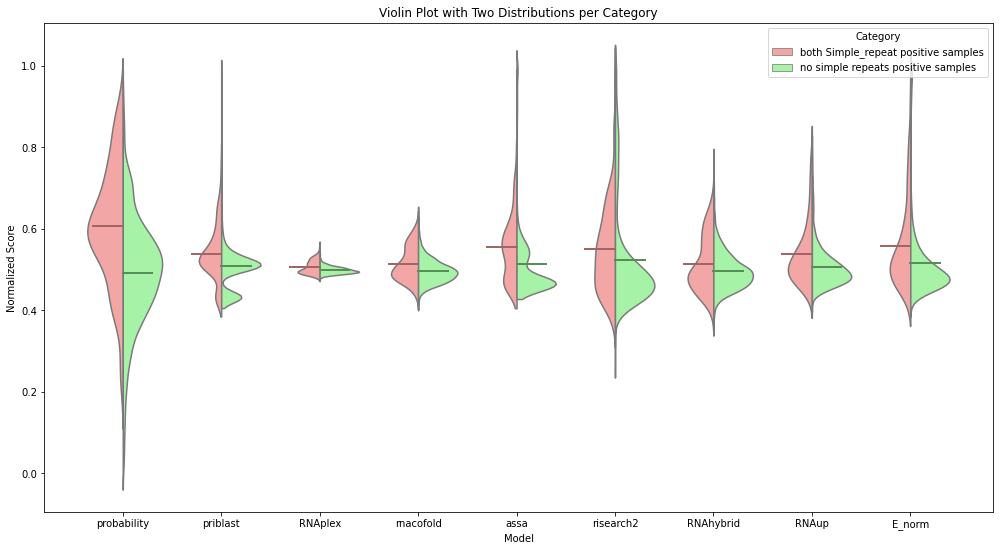




           -- -- -- simple_repeat_EPSN -- -- -- 
           -  -  -  precision_recall_curve  -  -  - 


/data01/giorgio/ENTER/envs/dnabert/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/data01/giorgio/ENTER/envs/dnabert/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/data01/giorgio/ENTER/envs/dnabert/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


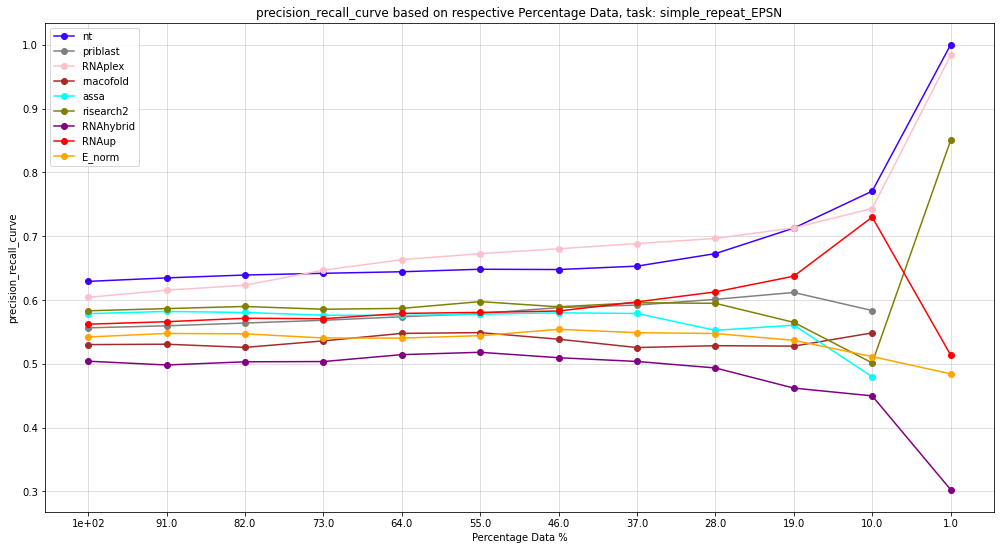

           -- -- -- no_simple_repeat_EPSN -- -- -- 
           -  -  -  precision_recall_curve  -  -  - 


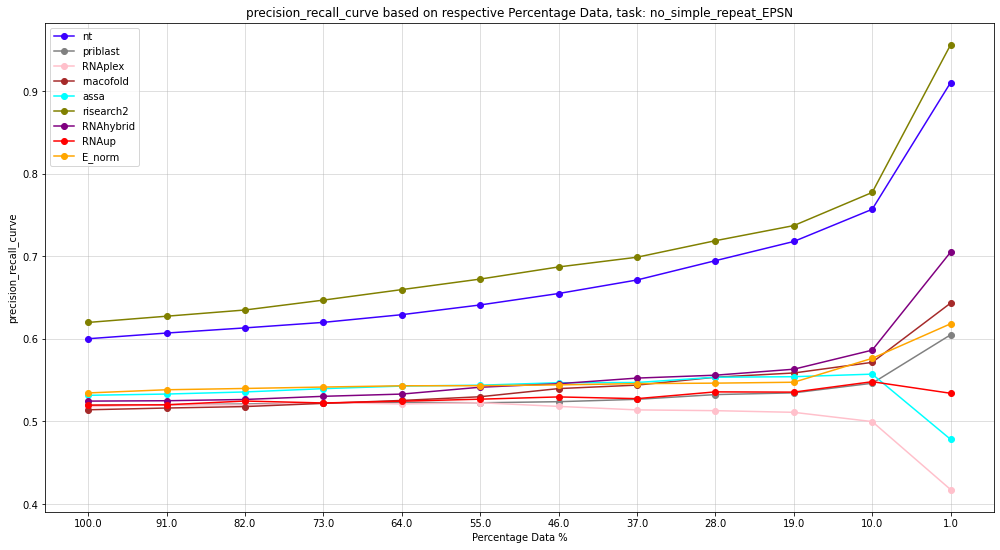




EASYPOS Percentage of SR in positive predictions based on model Confidence Levels


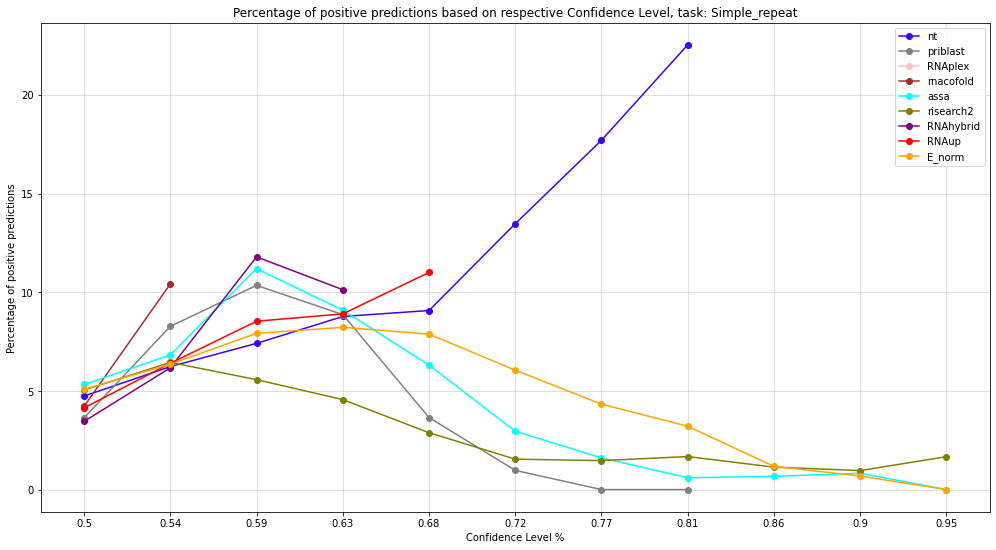

SMARTNEG Percentage of SR in positive predictions based on model Confidence Levels


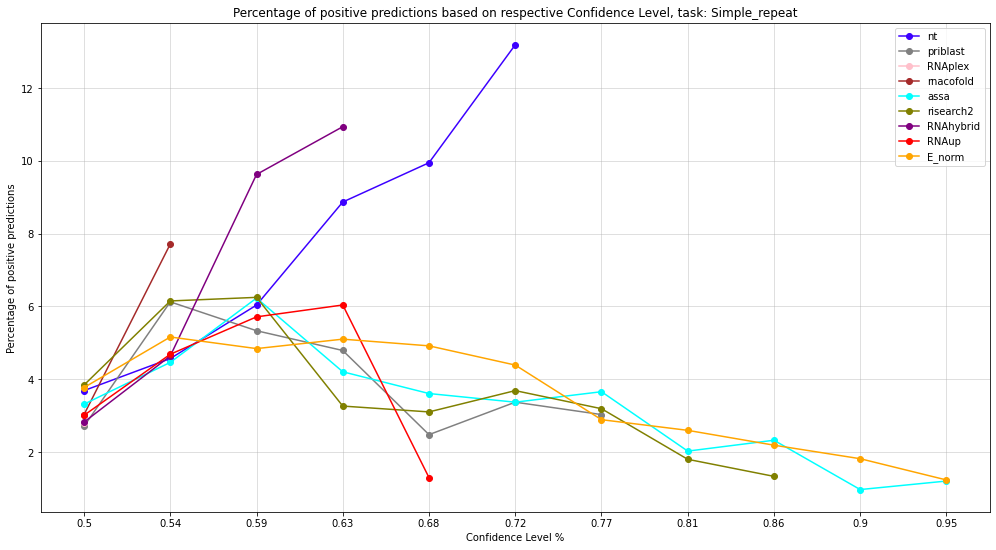




##############   ##############   ##############   ##############   ##############
---------- DATASET: ricseq ----------
# excluded couples:  234
Simple_repeat are the 1.5474573267969995  % of the total couples
No Simple_repeat are the 77.93396727895576  % of the total couples


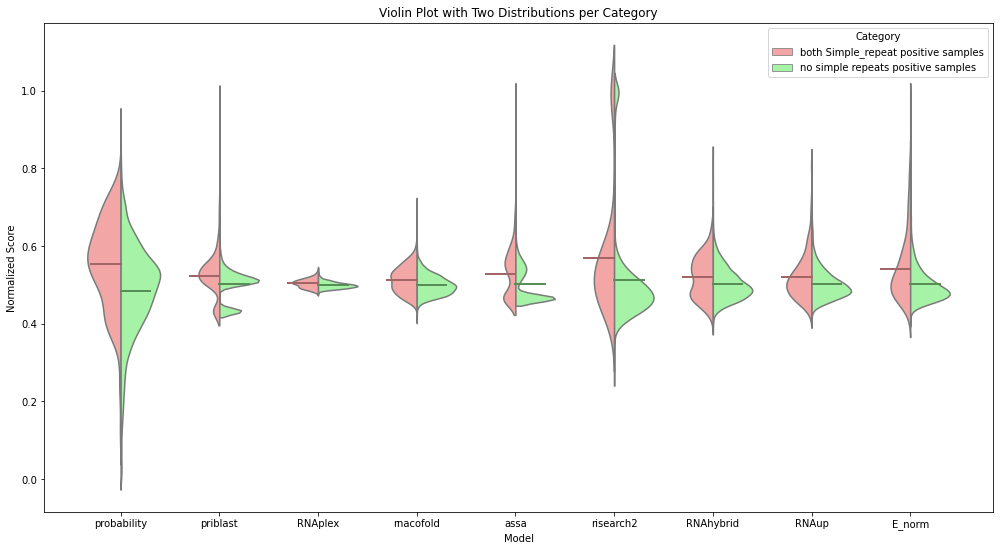




           -- -- -- simple_repeat_EPSN -- -- -- 
           -  -  -  precision_recall_curve  -  -  - 


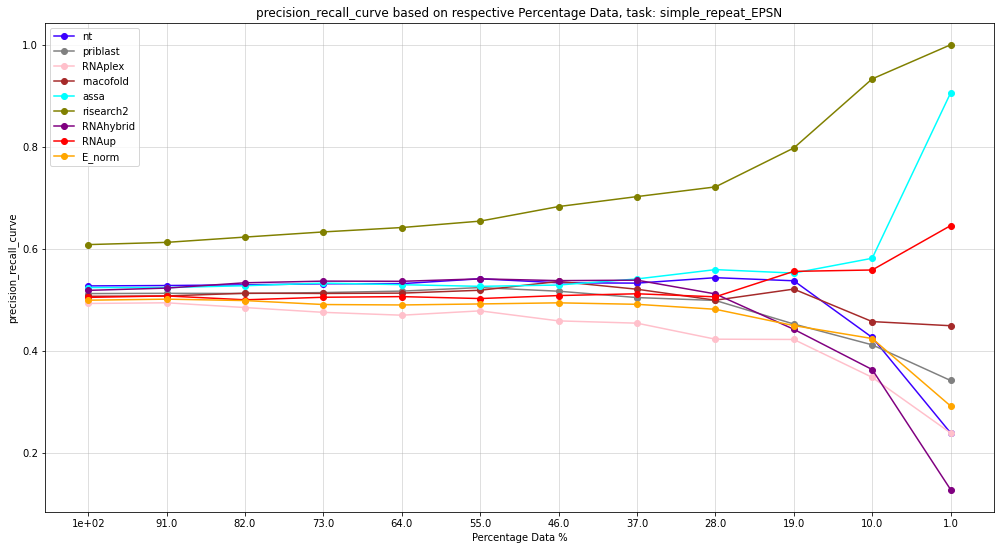

           -- -- -- no_simple_repeat_EPSN -- -- -- 
           -  -  -  precision_recall_curve  -  -  - 


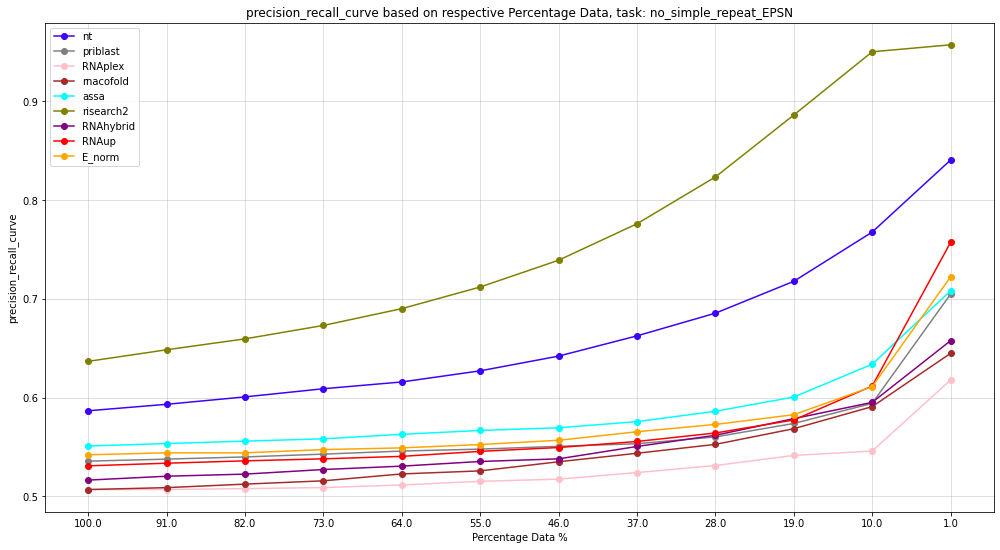




EASYPOS Percentage of SR in positive predictions based on model Confidence Levels


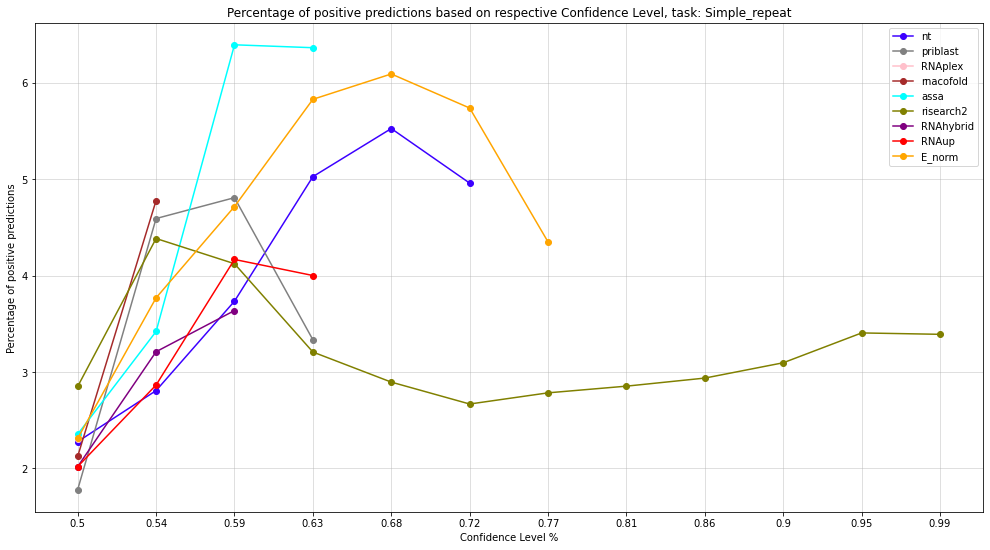

SMARTNEG Percentage of SR in positive predictions based on model Confidence Levels


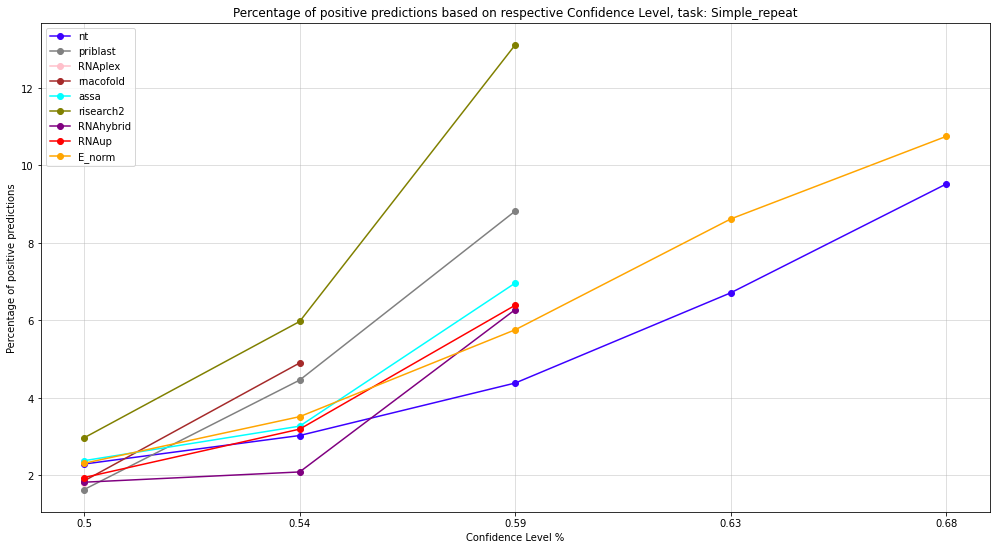




##############   ##############   ##############   ##############   ##############
---------- DATASET: mario ----------
# excluded couples:  4
Simple_repeat are the 1.0535557506584723  % of the total couples
No Simple_repeat are the 80.64091308165057  % of the total couples


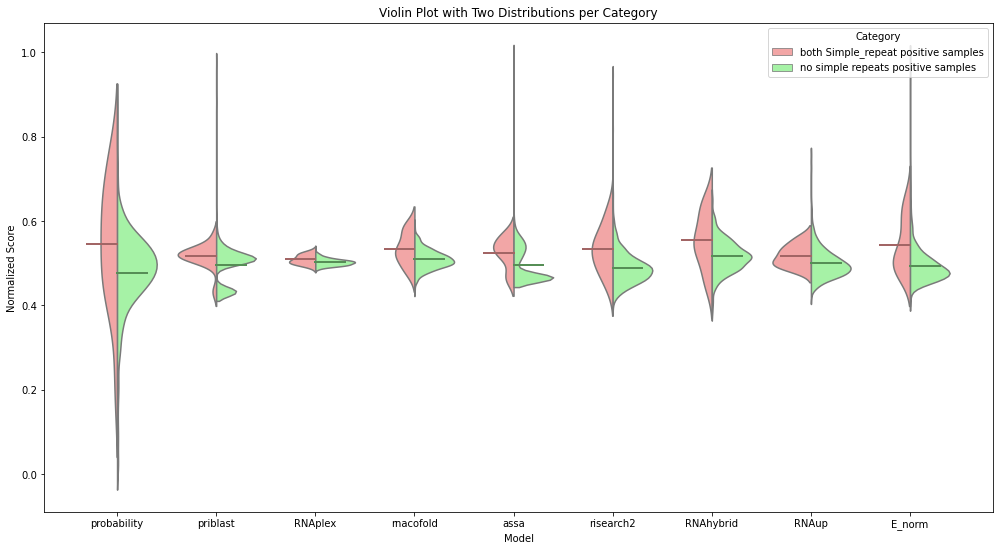




           -- -- -- simple_repeat_EPSN -- -- -- 
           -  -  -  precision_recall_curve  -  -  - 


/data01/giorgio/ENTER/envs/dnabert/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/data01/giorgio/ENTER/envs/dnabert/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/data01/giorgio/ENTER/envs/dnabert/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/data01/giorgio/ENTER/envs/dnabert/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/data01/giorgio/ENTER/envs/dnabert/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/data01/giorgio/ENTER/envs/dnabert/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning

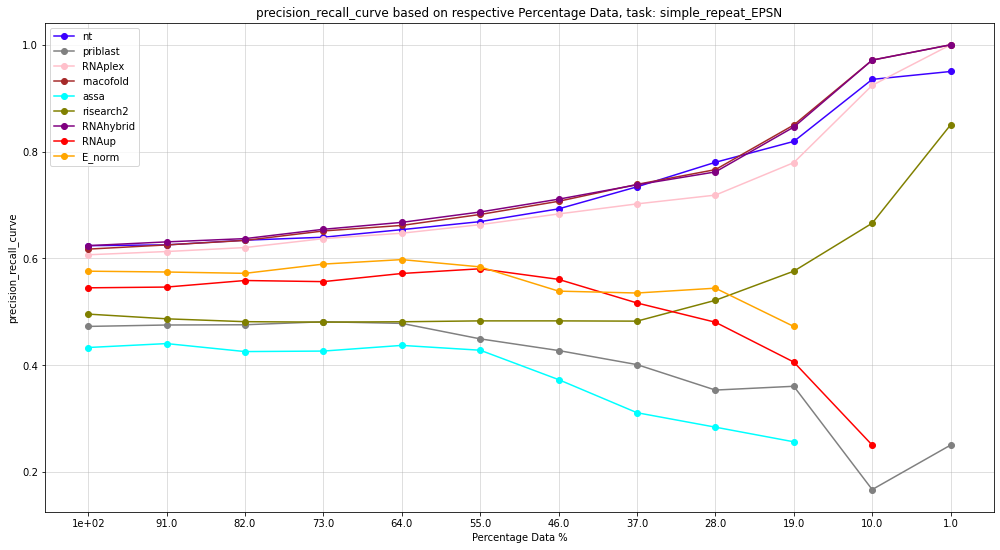

           -- -- -- no_simple_repeat_EPSN -- -- -- 
           -  -  -  precision_recall_curve  -  -  - 


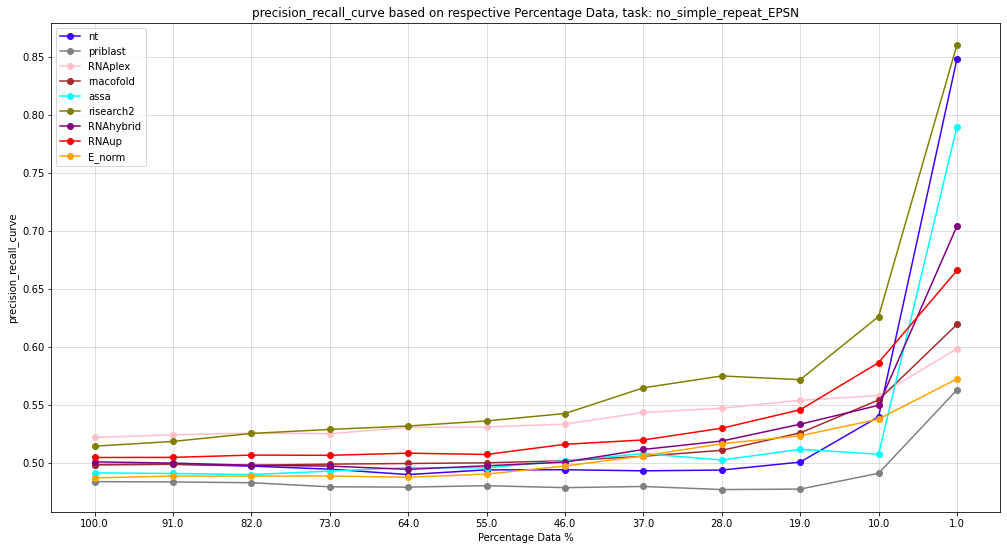




EASYPOS Percentage of SR in positive predictions based on model Confidence Levels


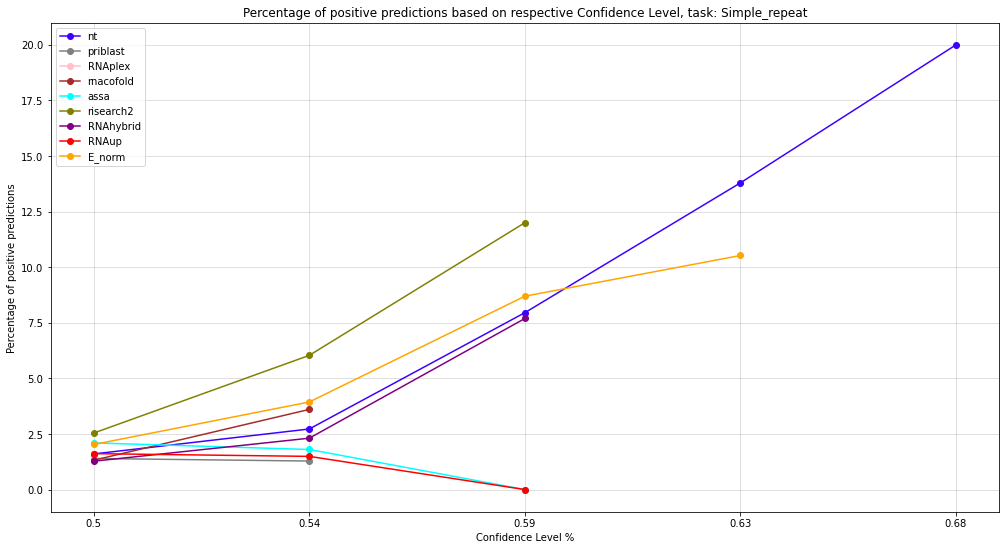

SMARTNEG Percentage of SR in positive predictions based on model Confidence Levels


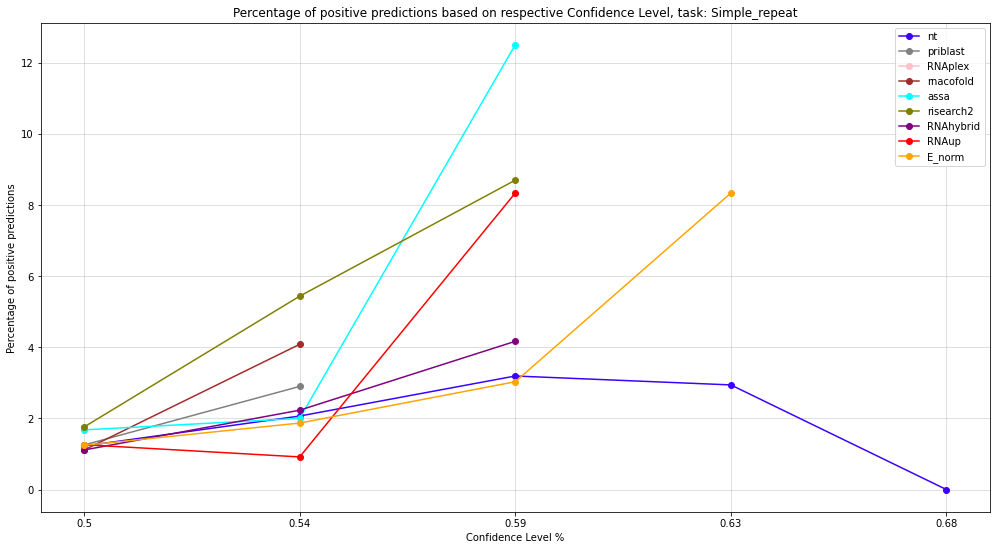

In [17]:
for dataset in ['psoralen', 'ricseq', 'mario']:
    print(f'##############   ##############   ##############   ##############   ##############')
    print(f'---------- DATASET: {dataset} ----------')

    res = load_test_set_df(external_dataset_dir, checkpoint_dir, tools, dataset, args_datasets)

    for model_column in energy_columns:
        lrm_dict = logistic_regression_models[model_column]
        X_test = np.expand_dims(res[model_column], 1)
        y_pred = log_func(lrm_dict['intercept'], lrm_dict['coef'], X_test)
        res[model_column] = pd.Series(y_pred.flatten()) #modify column according to the model mapping


    res['simple_repeat1'] = res[f'{suffix}feature1'].apply(lambda x: feature_to_search in x)
    res['simple_repeat2'] = res[f'{suffix}feature2'].apply(lambda x: feature_to_search in x)
    res['none1'] = res[f'{suffix}feature1'].apply(lambda x: 'None' in x)
    res['none2'] = res[f'{suffix}feature2'].apply(lambda x: feature_to_search in x)


    filtered_policies = ['easypos', 'smartneg']
    sr, no_sr = obtain_sr_nosr(res, both_sr_condition, filtered_policies)
    N_total_couples = len(set(res[res.policy.isin(filtered_policies)].id_sample))
    print(f'{feature_to_search} are the {len(set(sr.id_sample)) /  N_total_couples * 100}  % of the total couples')
    print(f'No {feature_to_search} are the {len(set(no_sr.id_sample)) /  N_total_couples * 100}  % of the total couples')


    sr_ep = sr[sr.policy == 'easypos'].reset_index(drop = True)
    sr_sn = sr[sr.policy == 'smartneg'].reset_index(drop = True)

    no_sr_ep = no_sr[no_sr.policy == 'easypos'].reset_index(drop = True)
    no_sr_sn = no_sr[no_sr.policy == 'smartneg'].reset_index(drop = True)
    
    
    
    df_sr = []
    for column in ['probability'] + energy_columns:

        if both_sr_condition:
            label_x = f'both {feature_to_search} positive samples'
        else:
            label_x = f'at least {feature_to_search} positive samples'

        x, y = sr_ep[column], no_sr_ep[column]
        
        df_model = pd.DataFrame({
                'Model': [column] * (len(x) + len(y)),
                'Category': pd.concat([
                    pd.Series([label_x] * len(x)), 
                    pd.Series(['no simple repeats positive samples'] * len(y))
                ]),
                'Normalized Score': pd.concat([x, y])
            })
        
        df_sr.append(df_model)
        
    df_sr = pd.concat(df_sr)

    plot_sr_distributions(df_sr, label_x, figsize = figsize_treshold)

    print('\n\n')
    
    ##################### ##################### TRESHOLD PLOTS ##################### #####################
        
    for metric in list_of_metrics:
    
        for task in tasks_treshold:
            print(f'           -- -- -- {task} -- -- -- ')
            print(f'           -  -  -  {metric}  -  -  - ')

            if task == 'simple_repeat_EPSN':
                assert len(sr.ground_truth.value_counts().index) == 2
                subset_to_plot = sr.reset_index(drop = True)
            elif task == 'no_simple_repeat_EPSN':
                assert len(no_sr.ground_truth.value_counts().index) == 2
                subset_to_plot = no_sr.reset_index(drop = True)

            plt.figure(figsize=figsize_treshold)
            plot_function(subset_to_plot, MIN_PERC = MIN_PERC, 
                          list_of_models_to_test = list_of_models_to_test, 
                          n_values = n_values, n_run_undersampling = n_run_undersampling, 
                          metric = metric, task_name = task, 
                          size_multiplier = size_multiplier#, balance_predictions_at_each_step = True
                         )
            plt.show()
            
    print('\n\n')
    
    ##################### ##################### REPEATS IN POSITIVE PREDICTIONS ##################### #####################
    #Percentage of SR in positive predictions based on model Confidence Levels (questo prende in considerazione tutti i positivi, e vediamo se all aumentare del livello di confidenza predilige le repeats)
    print('EASYPOS Percentage of SR in positive predictions based on model Confidence Levels')
    plt.figure(figsize=figsize_treshold)
    plot_results_how_many_repeats_in_pred_pos_for_all_models(res[res.policy == 'easypos'].reset_index(drop = True),
                                                             MIN_PERC, list_of_models_to_test, n_values = n_values, both_sr = both_sr_condition, feature_to_search = feature_to_search
                                                            )
    print('SMARTNEG Percentage of SR in positive predictions based on model Confidence Levels')
    plt.figure(figsize=figsize_treshold)
    plot_results_how_many_repeats_in_pred_pos_for_all_models(res[res.policy == 'smartneg'].reset_index(drop = True),
                                                             MIN_PERC, list_of_models_to_test, n_values = n_values, both_sr = both_sr_condition, feature_to_search = feature_to_search
                                                            ) #these are errors
    
    
    print('\n\n')
#     ##################### ##################### KDE PLOTS ##################### #####################
    
#     for column in ['probability'] + energy_columns:

#         if both_sr_condition:
#             label_x = f'both {feature_to_search} positive samples'
#         else:
#             label_x = f'at least {feature_to_search} positive samples'

#         x, y = sr_ep[column], no_sr_ep[column]

#         make_plot_kde_and_test_difference(x, y, label_x, 'no simple repeats positive samples', column, figsize_kde)

#         if both_sr_condition:
#             label_x = f'both {feature_to_search} positive samples'
#             label_y = f'both {feature_to_search} smartneg samples'
#         else:
#             label_x = f'at least {feature_to_search} positive samples'
#             label_y = f'at least {feature_to_search} smartneg samples'

#         x, y = sr_ep[column], sr_sn[column]

#         make_plot_kde_and_test_difference(x, y, label_x, label_y, column, figsize_kde)
        
#     print('\n\n')

### How good is in predicting EN in the same embedding matrixes of SN? How good is in predicting HN in the same embedding matrixes of EP?
### Patches task depend on the distance from the interaction site

# excluded couples:  12
---------- DATASET: psoralen ----------


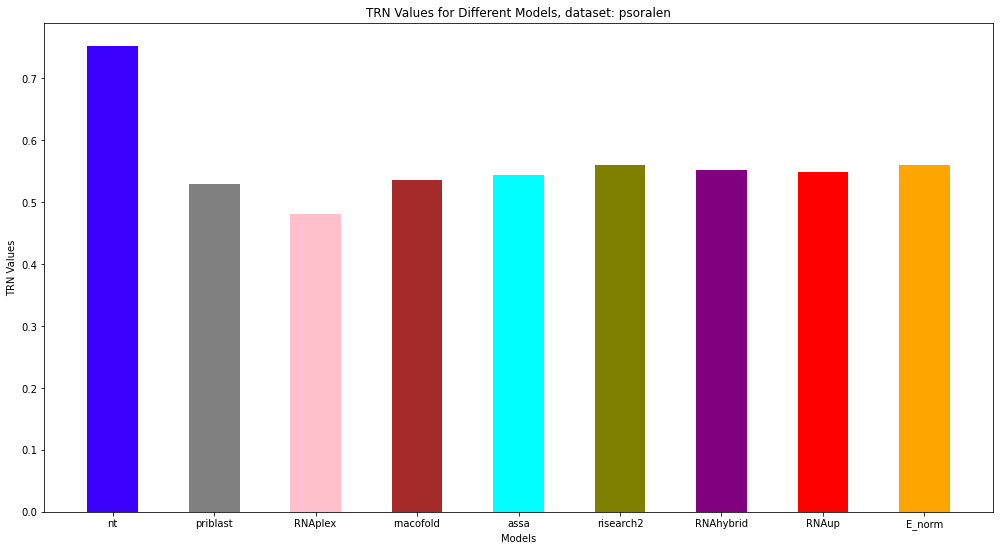

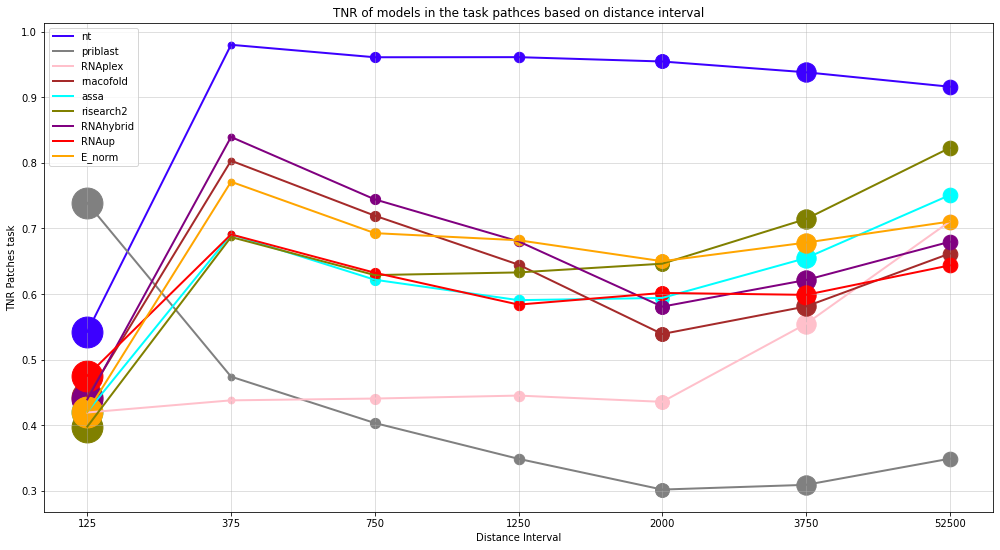

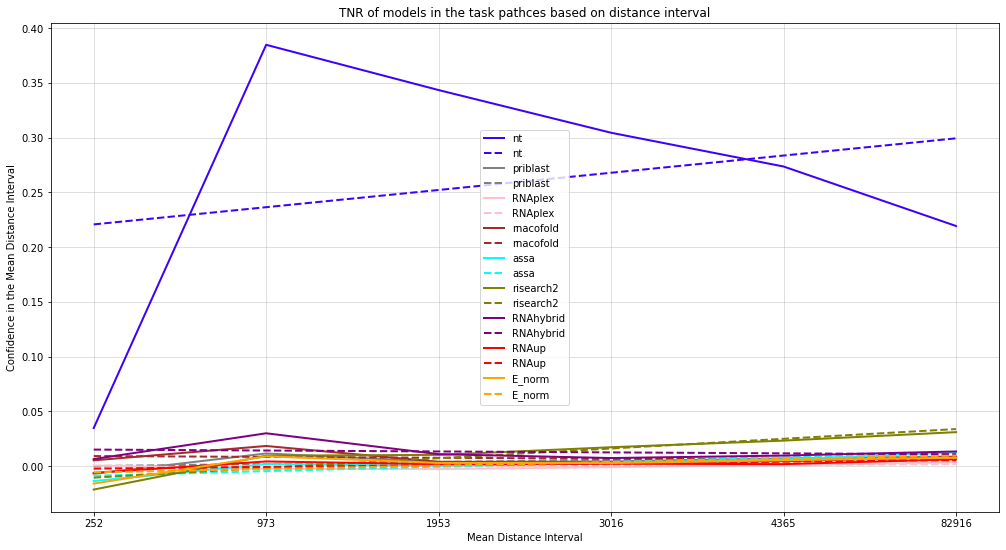

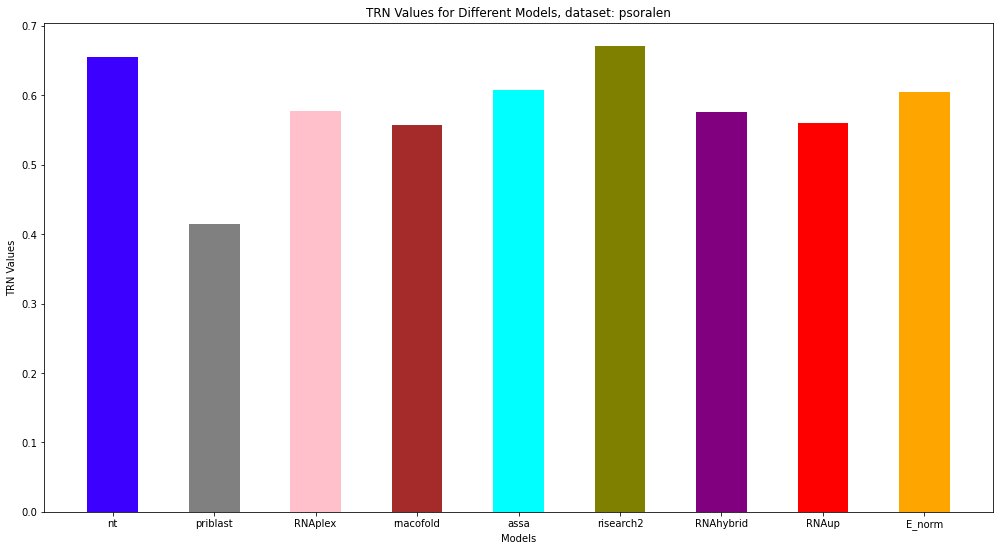

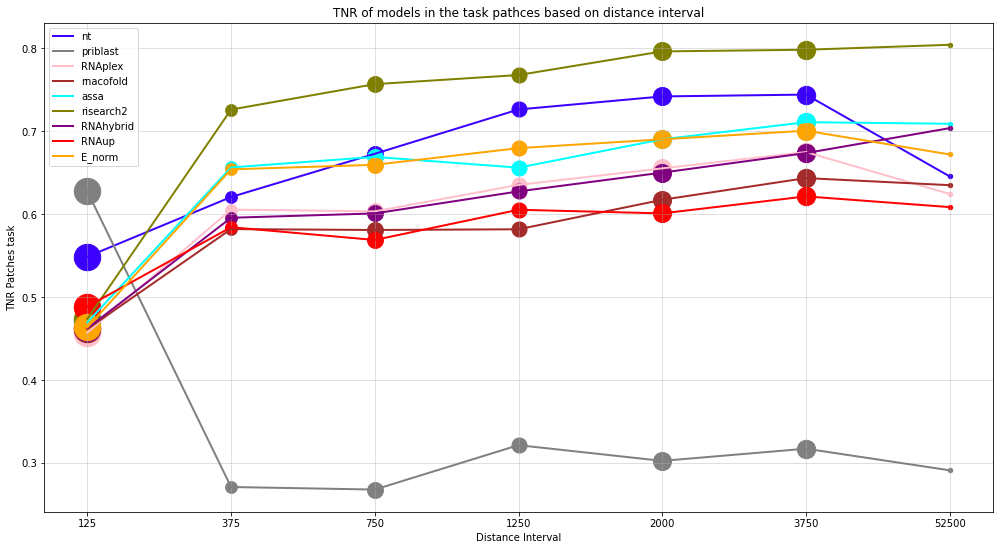

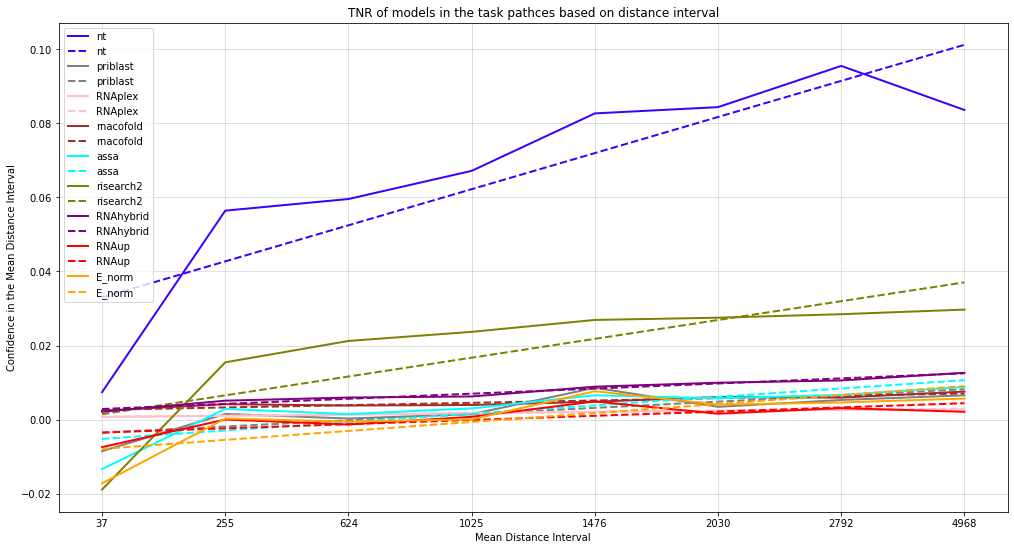

# excluded couples:  234
---------- DATASET: ricseq ----------


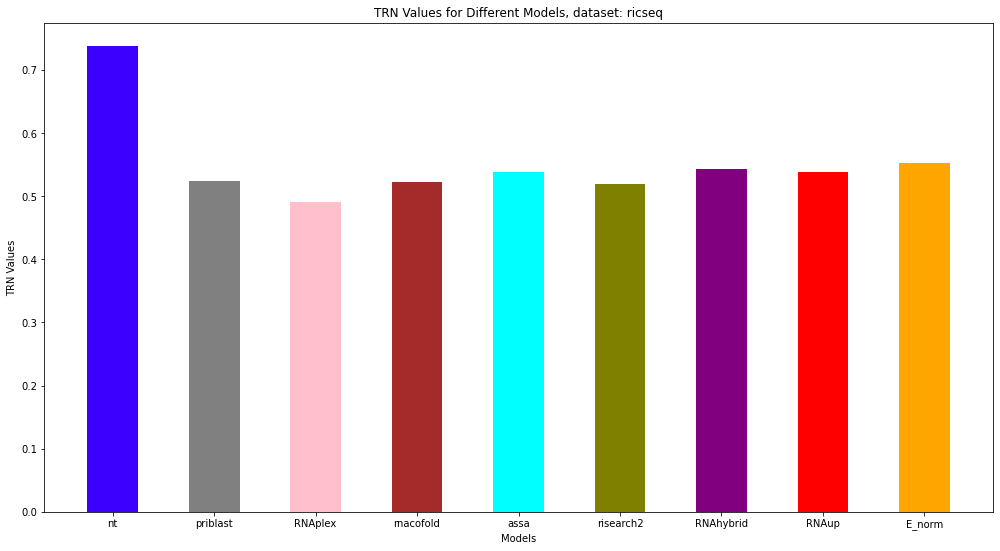

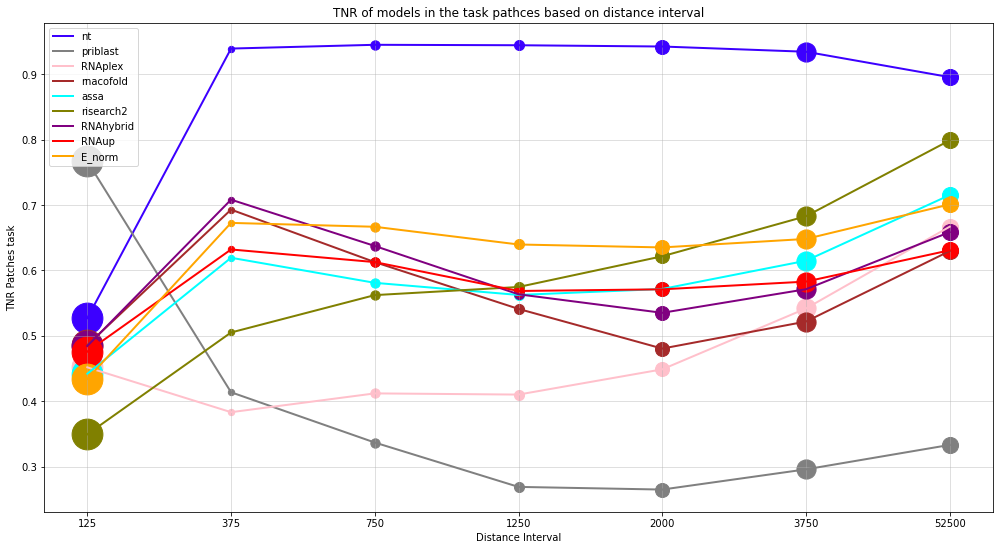

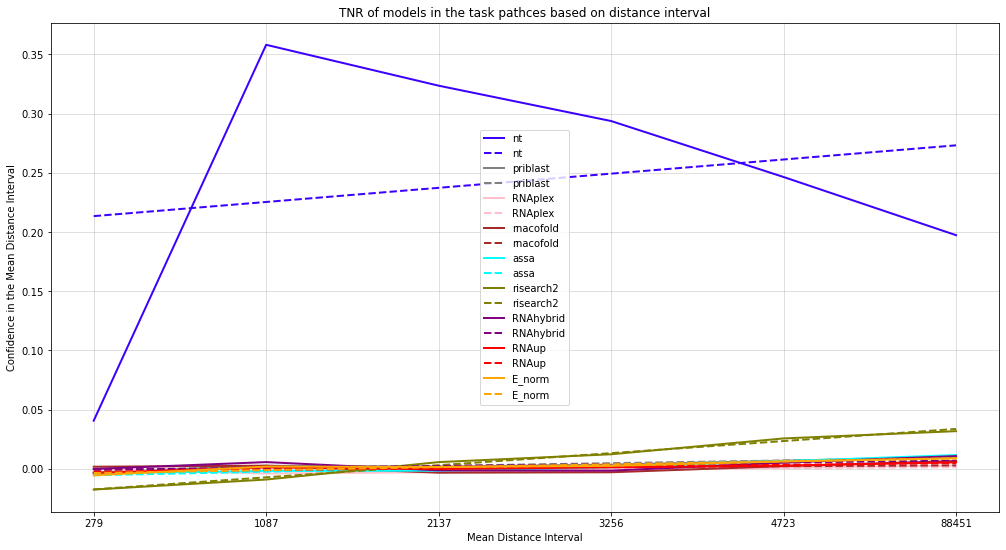

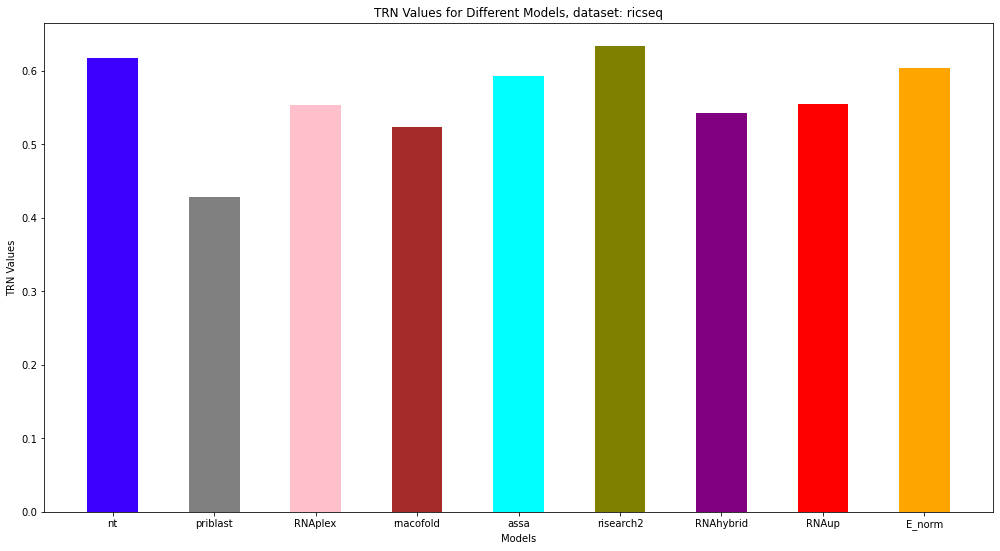

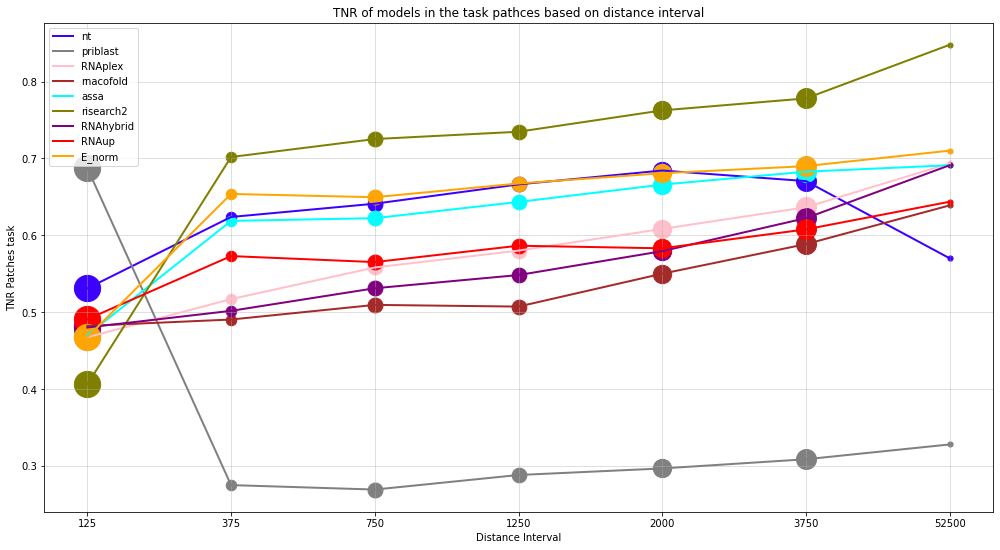

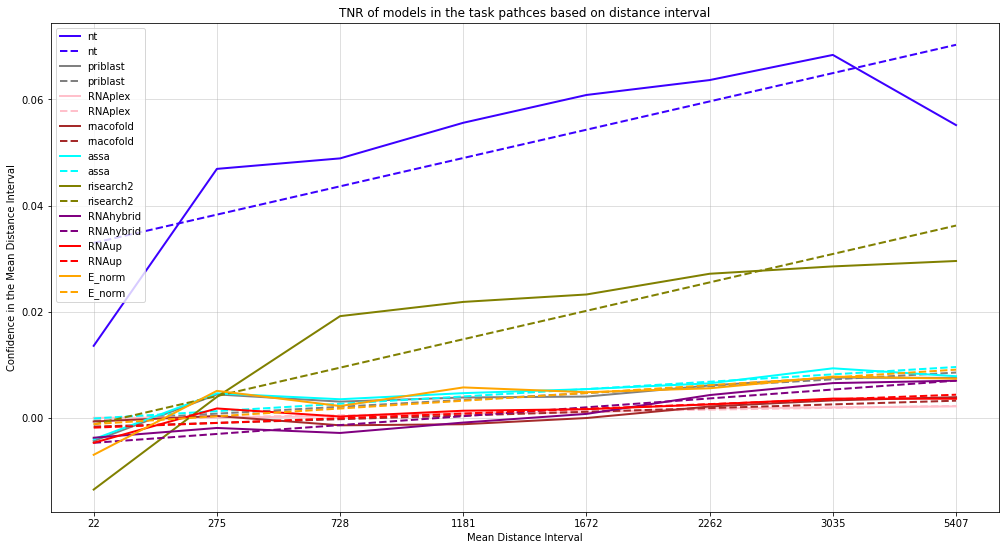

# excluded couples:  4
---------- DATASET: mario ----------


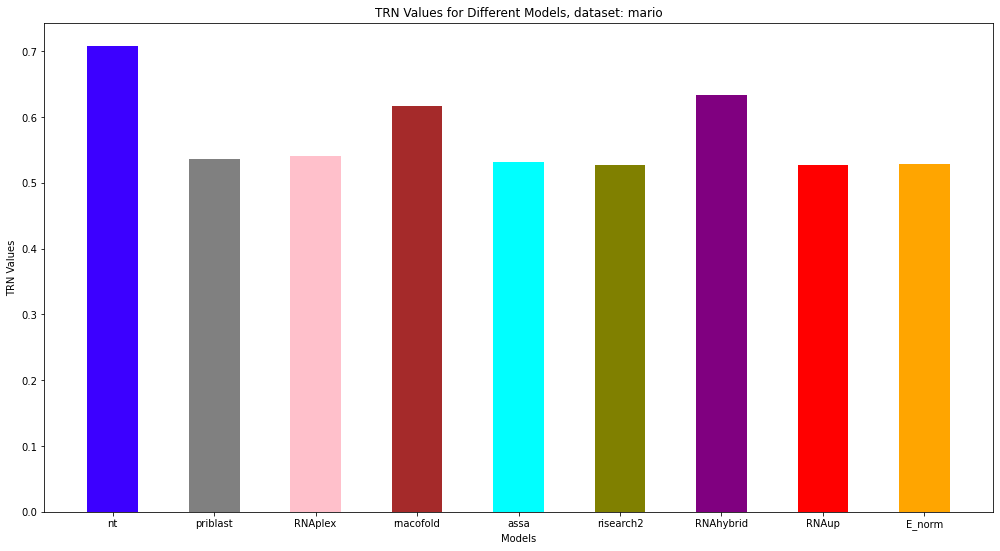

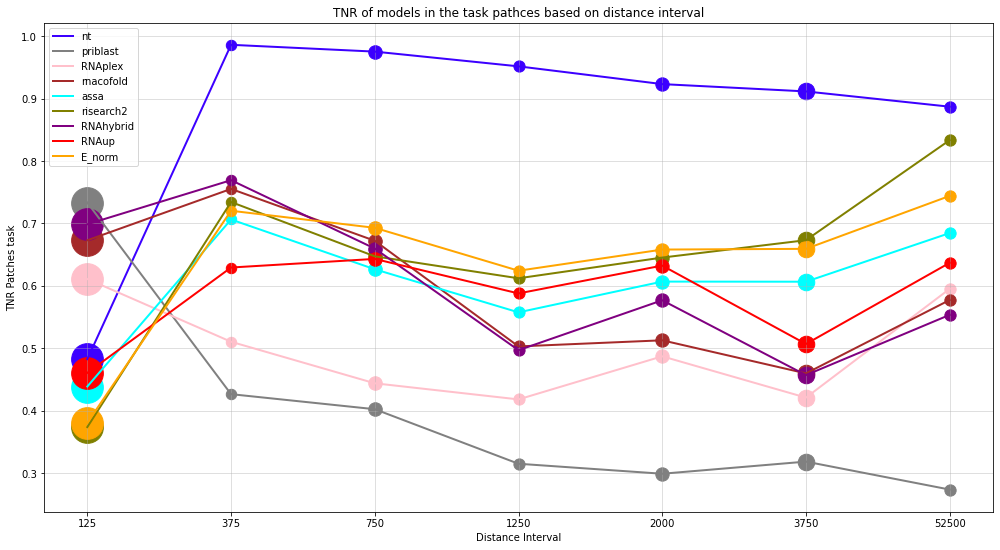

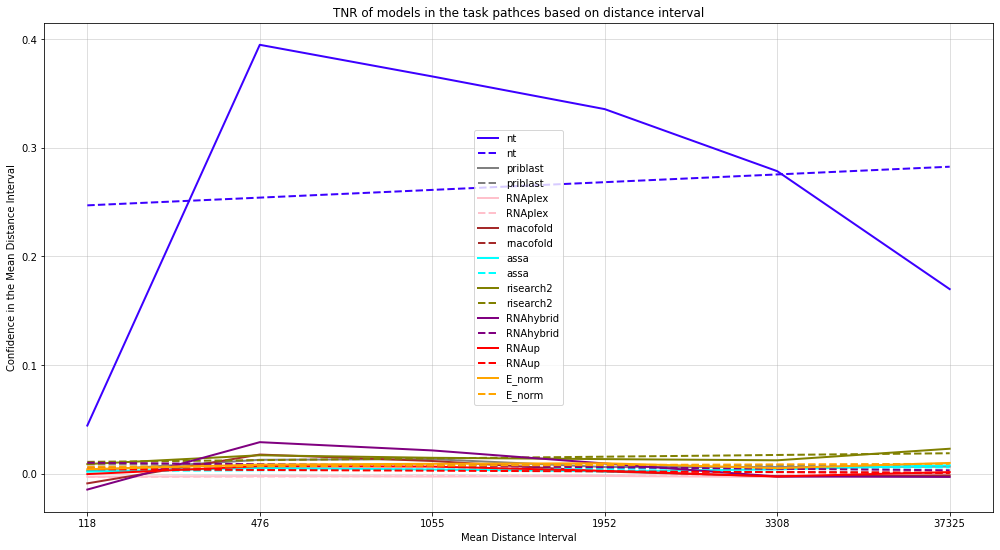

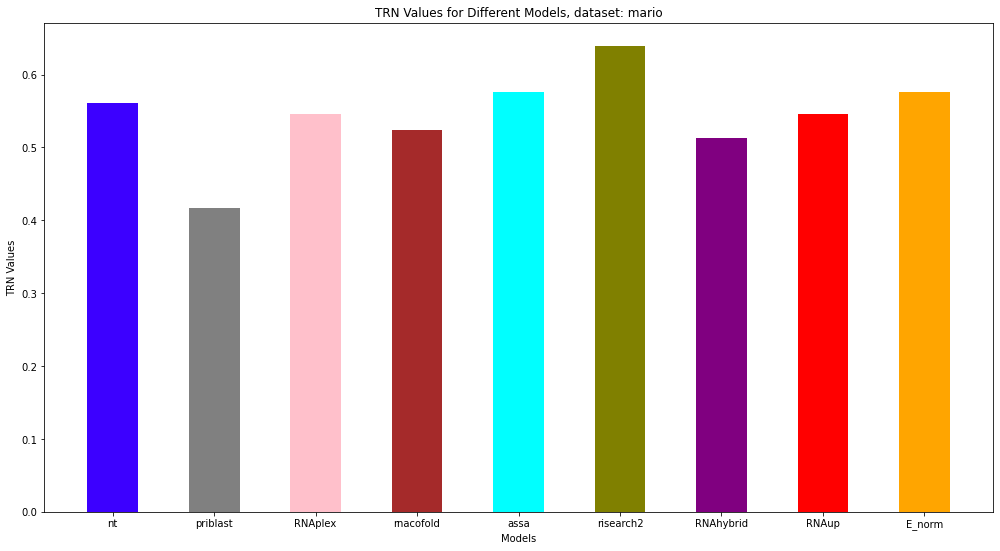

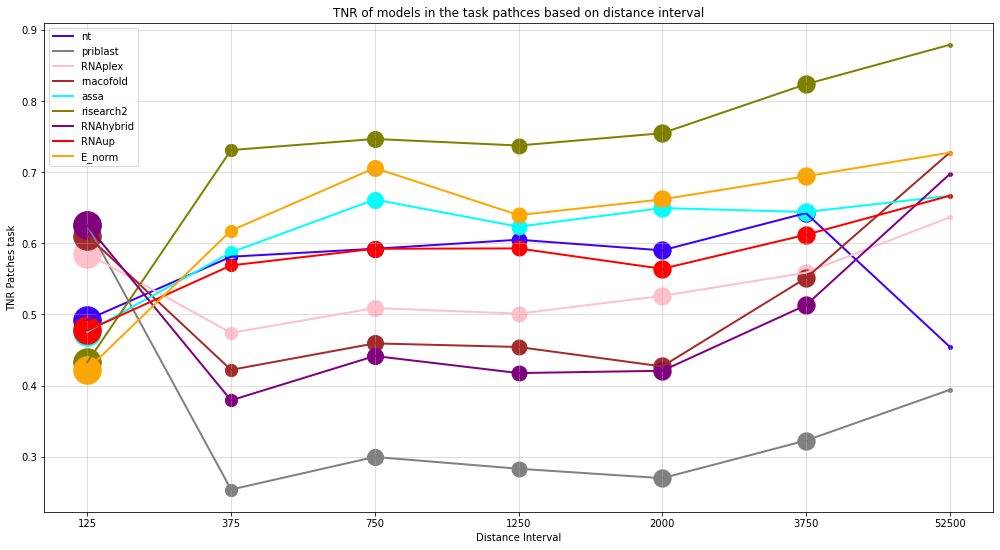

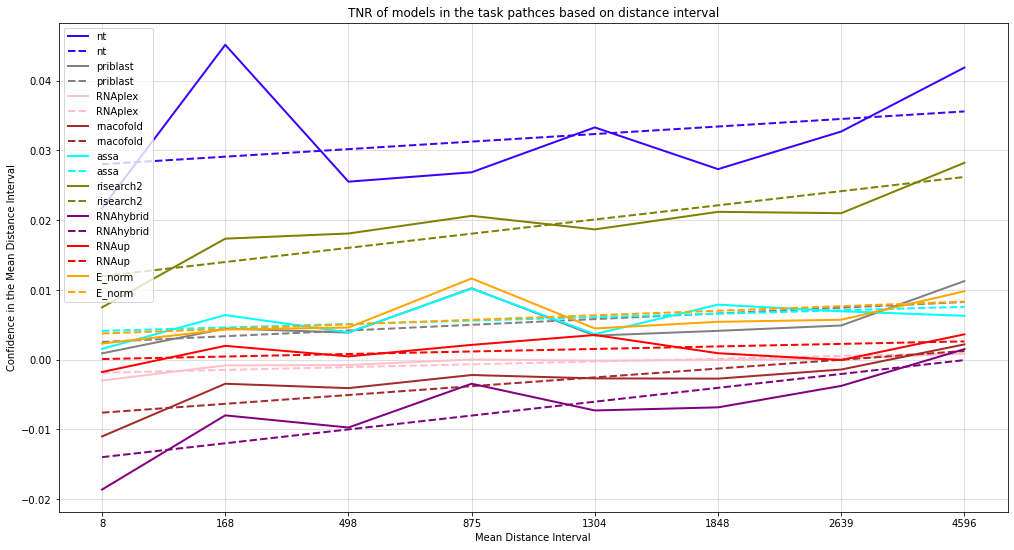

In [18]:
figsize = (17, 9)
size_multiplier = 20
bins_distance = [[0, 250], [250, 500], [500, 1_000], [1_000, 1_500], [1_500, 2_500], [2_500, 5_000], [5_000, 100_000]]




dfs = []

for dataset in ['psoralen', 'ricseq', 'mario']:
    res = load_test_set_df(external_dataset_dir, checkpoint_dir, tools, dataset, args_datasets)
    
    for model_column in energy_columns:
        lrm_dict = logistic_regression_models[model_column]
        X_test = np.expand_dims(res[model_column], 1)
        y_pred = log_func(lrm_dict['intercept'], lrm_dict['coef'], X_test)
        res[model_column] = pd.Series(y_pred.flatten()) #modify column according to the model mapping
        
    easypos_smartneg, ephnen, enhn500 = obtain_epsn_ephnen_from_res(res) 

            
    print(f'---------- DATASET: {dataset} ----------')
        
    for subset_to_plot in [ephnen.copy().reset_index(drop = True), enhn500.copy().reset_index(drop = True)]:
        plot_tnr_for_all_models(list_of_models_to_test, #['nt']
                                subset_to_plot, 
                                figsize = figsize, 
                                title_suffix = f'dataset: {dataset}', 
                                bar_width = 0.5
                               )
        plot_tnr_based_on_distance_for_all_models(subset_to_plot,
                                                  bins_distance,
                                                  list_of_models_to_test, #['nt']
                                                  figsize=figsize, 
                                                  size_multiplier = size_multiplier
                                                 )
        
        n_values = 10
        bins_distance_quantile = quantile_bins(subset_to_plot.distance_from_site, n_values)
        plot_confidence_based_on_distance_for_all_models(subset_to_plot, 
                                                         bins_distance_quantile, 
                                                         list_of_models_to_test, #['nt']
                                                         figsize)

### Plots based on top-bottom

In [19]:
#plot parameters
list_of_models_to_test = ['nt'] + energy_columns
n_values = 12
n_run_undersampling = 10
figsize = (17,9)
size_multiplier = 10

checkpoint_dir = [os.path.join(ROOT_DIR, 'checkpoints', _) for _ in nt_models]
list_of_models_to_test = list_of_models_to_test + [f'nt{_}' for _ in range(1, len(nt_models))]


MIN_PERC = 1
list_of_metrics = ['precision', 'npv'] #['f1','precision', 'npv'] #[['f1','precision', 'npv', 'recall', 'specificity', 'precision_recall_curve']
balance_predictions_at_each_step=False

In [20]:
from util.plot_utils import collect_results_based_on_topbottom_for_all_models
from mpl_toolkits.axes_grid1 import make_axes_locatable

def npv_precision(precision_data, npv_data, model_names, figsize):
    assert precision_data.shape == npv_data.shape
    
    num_modelli, n_points =  precision_data.shape[0], precision_data.shape[1]
    
    percentuali_neg = np.linspace(1, 100, num=n_points).astype(int)
    percentuali_pos = np.linspace(1, 100, num=n_points).astype(int)[::-1]

    percentuali = np.concatenate((percentuali_neg, percentuali_pos))
    
    # Unione dei dati di precisione e NPV in un unico array per l'asse Y
    combined_data = np.hstack((npv_data, precision_data))

    # Creiamo un array per la combinazione delle due colormap
    combined_image = np.zeros((num_modelli, 2*n_points, 3))

    # Applichiamo la colormap 'Oranges' alla parte sinistra (NPV)
    norm = plt.Normalize(vmin=0, vmax=1)
    npv_colored = plt.cm.Oranges(norm(npv_data))[:, :, :3]  # Consideriamo solo i primi tre canali (RGB)
    combined_image[:, :n_points, :] = npv_colored

    # Applichiamo la colormap 'Blues' alla parte destra (Precision)
    precision_colored = plt.cm.Blues(norm(precision_data))[:, :, :3]  # Consideriamo solo i primi tre canali (RGB)
    combined_image[:, n_points:, :] = precision_colored

    # Plotting
    fig, ax = plt.subplots(figsize=figsize)

    # Creiamo il grafico principale
    im = ax.imshow(combined_image, aspect='auto', interpolation='nearest')
    plt.xlabel('Percentage of bottom / top predictions (%)')
    plt.ylabel('Model')
    plt.axvline(x=n_points-0.5, color='black', linestyle='--', label='Threshold between positive and negative predictions')
    plt.title('NPV over bottom predictions (left), Precision over top predictions (right)')
    plt.xticks(np.arange(len(percentuali)), percentuali)
    plt.yticks(np.arange(num_modelli), model_names)

    # Divider per le due colorbar
    divider = make_axes_locatable(ax)
    cax1 = divider.append_axes("right", size="5%", pad=0.1)
    cax2 = divider.append_axes("right", size="5%", pad=0.7)

    # Colorbar per NPV
    cb1 = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap='Oranges'), cax=cax1)
    cb1.set_label('NPV Score')

    # Colorbar per Precision
    cb2 = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap='Blues'), cax=cax2)
    cb2.set_label('Precision Score')

    # Aggiungiamo i numeri alle celle del grafico
    for i in range(num_modelli):
        for j in range(n_points):
            text = ax.text(j, i, f"{npv_data[i, j]:.2f}", ha="center", va="center", color="white", fontweight='bold')
            text = ax.text(j + n_points, i, f"{precision_data[i, j]:.2f}", ha="center", va="center", color="white", fontweight='bold')

    plt.legend()

    plt.tight_layout()
    plt.show()
    
    
def obtain_all_model_auc_patches(res, tools, n_runs=50):
    # Separate the dataset into positive and two types of negative samples
    pos = res[(res.policy == 'easypos')].reset_index(drop=True)
    neg_close = res[((res.distance_from_site_embedding == 0) & (res.policy.isin(['hardneg', 'easyneg'])))].reset_index(drop=True)
    neg_far = res[((res.distance_from_site_embedding > 0) & (res.policy.isin(['hardneg', 'easyneg'])))].reset_index(drop=True)
    
    # Initialize dictionary to store AUCs
    aucs_dict = {tool_name: [] for tool_name in ['NT', 'INTARNA'] + tools}
    
    if not (pos.shape[0] == neg_close.shape[0] == neg_far.shape[0]):
        for _ in range(n_runs):
            # Find the minimum size among the datasets
            min_size = min(pos.shape[0], neg_close.shape[0], neg_far.shape[0])
            
            # Undersample each dataset to the minimum size
            pos_sample = pos.sample(n=min_size, random_state=np.random.randint(0, 10000))
            neg_close_sample = neg_close.sample(n=min_size, random_state=np.random.randint(0, 10000))
            neg_far_sample = neg_far.sample(n=min_size, random_state=np.random.randint(0, 10000))
            
            # Combine the undersampled datasets
            balanced_subset = pd.concat([pos_sample, neg_close_sample, neg_far_sample])
            
            # Calculate AUC for each model/tool
            fpr, tpr, _ = roc_curve(balanced_subset.ground_truth, balanced_subset['probability'])
            aucs_dict['NT'].append(auc(fpr, tpr))
            
            fpr, tpr, _ = roc_curve(balanced_subset.ground_truth, abs(balanced_subset['E_norm']))
            aucs_dict['INTARNA'].append(auc(fpr, tpr))
            
            for tool_name in tools:
                fpr, tpr, _ = roc_curve(balanced_subset.ground_truth, abs(balanced_subset[tool_name]))
                aucs_dict[tool_name].append(auc(fpr, tpr))
        
        # Calculate mean AUC for each model/tool
        mean_aucs = {tool_name: np.mean(aucs_dict[tool_name]) for tool_name in aucs_dict}
    else:
        balanced_subset = pd.concat([pos, neg_close, neg_far])
        
        # Calculate AUC for each model/tool
        fpr, tpr, _ = roc_curve(balanced_subset.ground_truth, balanced_subset['probability'])
        aucs_dict['NT'].append(auc(fpr, tpr))
        
        fpr, tpr, _ = roc_curve(balanced_subset.ground_truth, abs(balanced_subset['E_norm']))
        aucs_dict['INTARNA'].append(auc(fpr, tpr))
        
        for tool_name in tools:
            fpr, tpr, _ = roc_curve(balanced_subset.ground_truth, abs(balanced_subset[tool_name]))
            aucs_dict[tool_name].append(auc(fpr, tpr))
        
        # Calculate mean AUC for each model/tool
        mean_aucs = {tool_name: np.mean(aucs_dict[tool_name]) for tool_name in aucs_dict}
    
    # Create DataFrame with results
    df_out = pd.DataFrame({
        'model_name': list(mean_aucs.keys()),
        'auc': [round(auc, 2) for auc in mean_aucs.values()]
    })
    
    return df_out

# excluded couples:  12
psoralen interactors


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


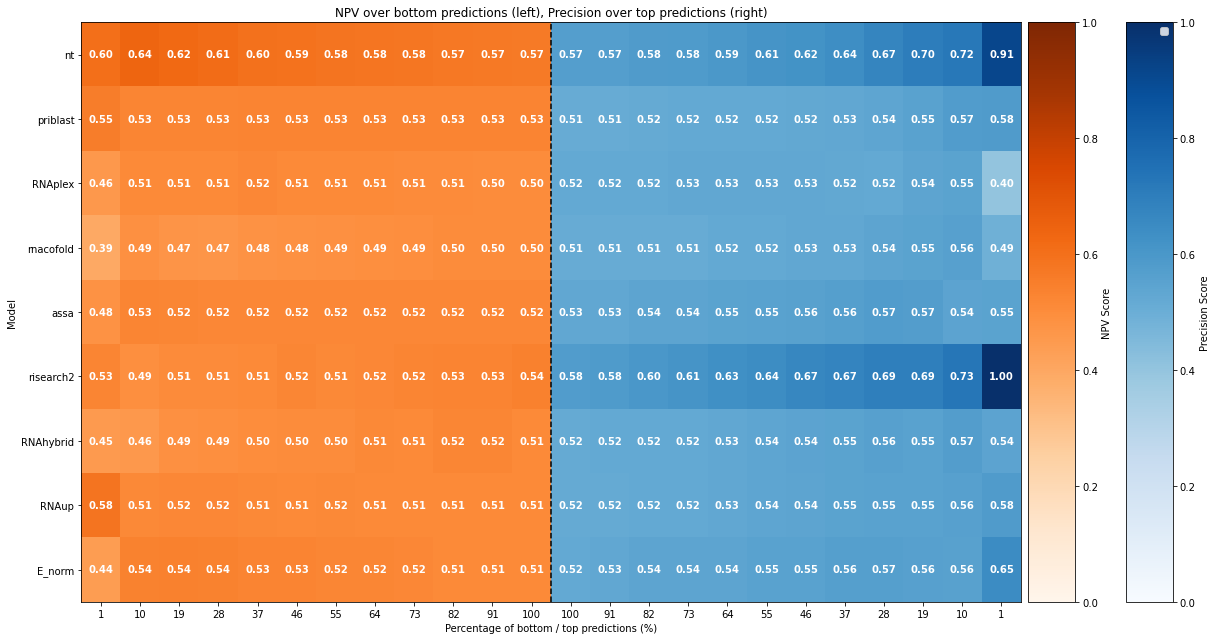

psoralen patches


/data01/giorgio/ENTER/envs/dnabert/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/data01/giorgio/ENTER/envs/dnabert/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


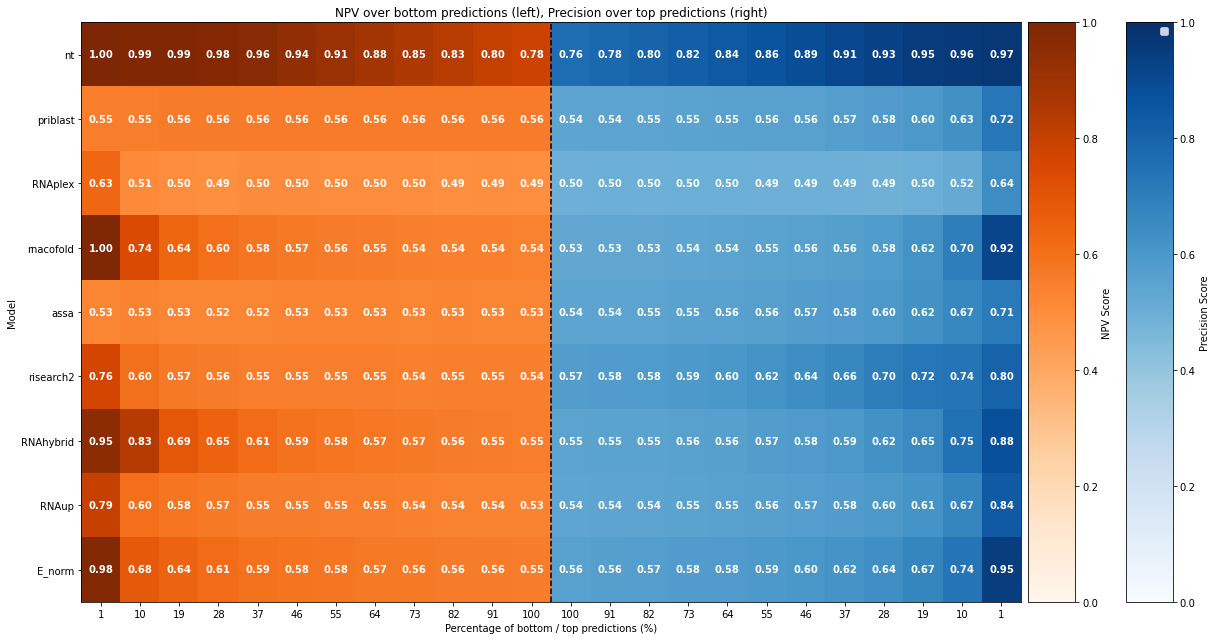

# excluded couples:  234
ricseq interactors


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


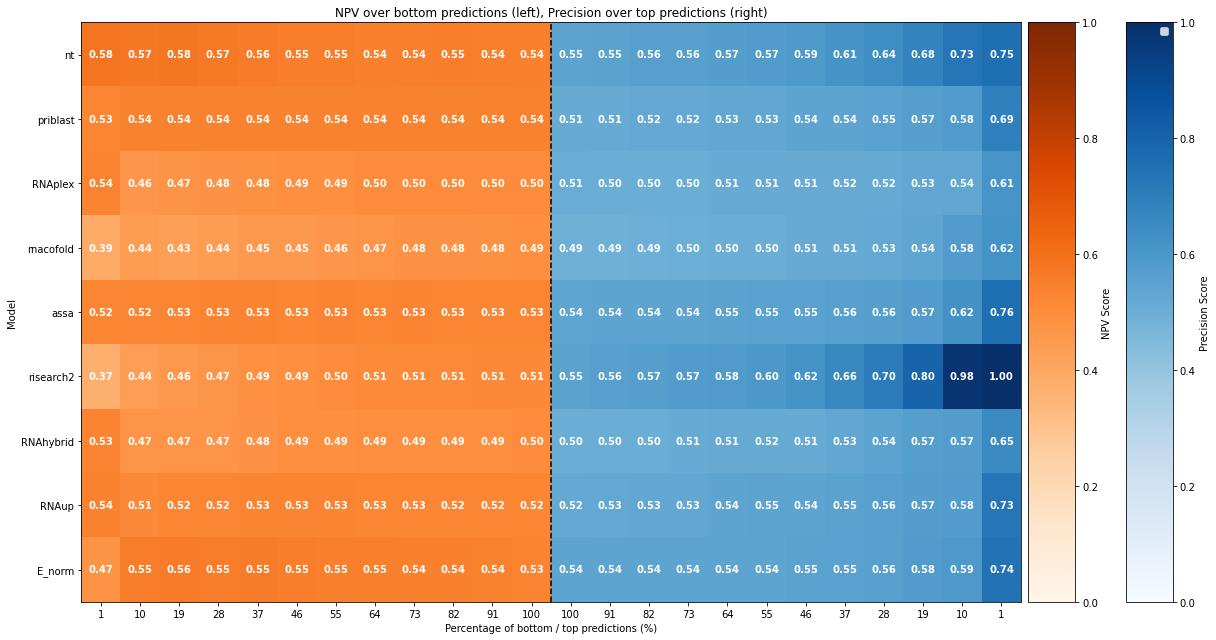

ricseq patches


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


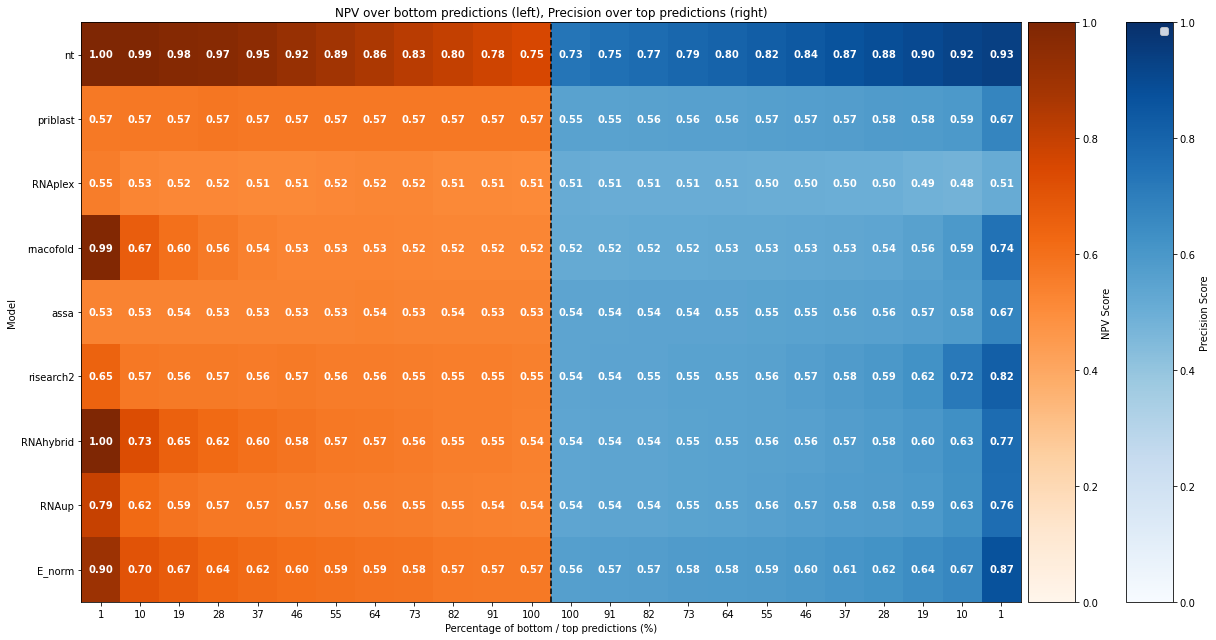

# excluded couples:  4
mario interactors


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


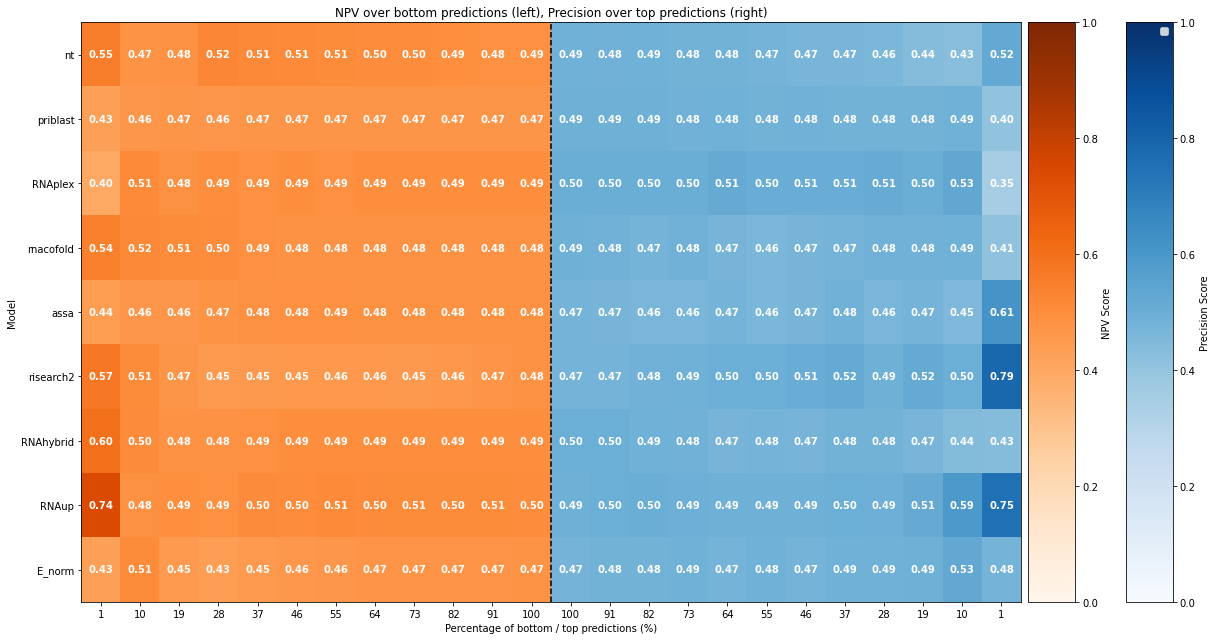

mario patches


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


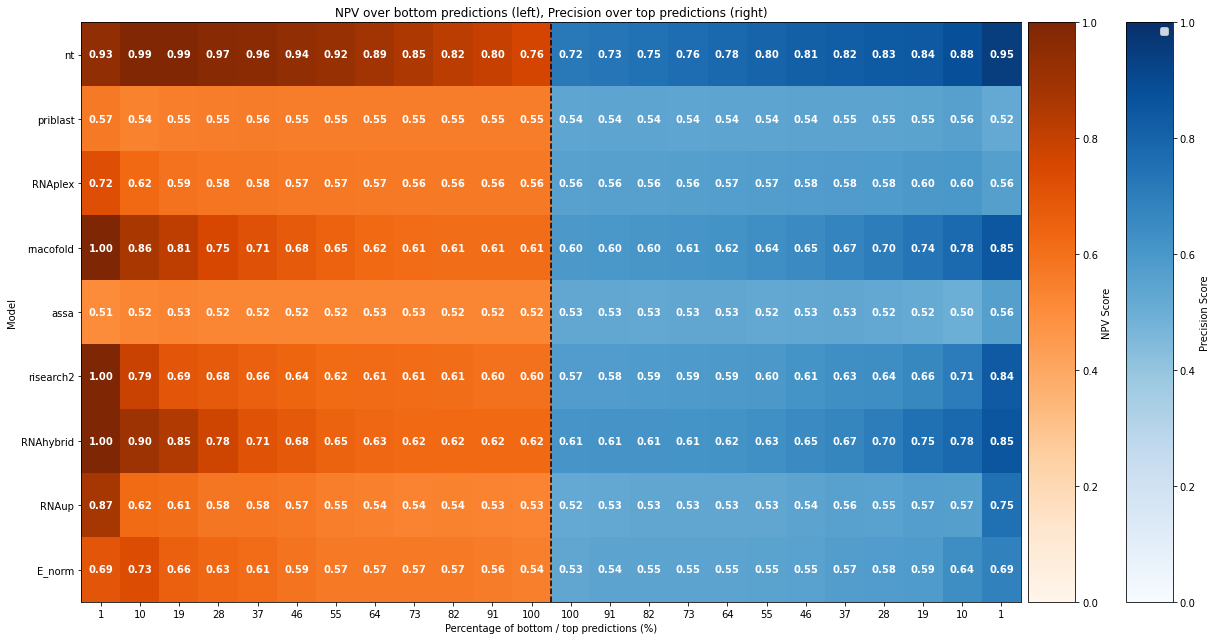

In [21]:
n_runs_patches = 10

for dataset in ['psoralen', 'ricseq', 'mario']:
    
    res = load_test_set_df(external_dataset_dir, checkpoint_dir, tools, dataset, args_datasets)
    
    for model_column in energy_columns:
        lrm_dict = logistic_regression_models[model_column]
        X_test = np.expand_dims(res[model_column], 1)
        y_pred = log_func(lrm_dict['intercept'], lrm_dict['coef'], X_test)
        res[model_column] = pd.Series(y_pred.flatten()) #modify column according to the model mapping
    
    easypos_smartneg, ephnen, enhn500 = obtain_epsn_ephnen_from_res(res) 
    
    #interactors
    print(dataset, 'interactors')
    precision_data, _, model_names = collect_results_based_on_topbottom_for_all_models(easypos_smartneg, MIN_PERC, list_of_models_to_test, n_values, n_run_undersampling, 'precision')
    npv_models, _, model_names = collect_results_based_on_topbottom_for_all_models(easypos_smartneg, MIN_PERC, list_of_models_to_test, n_values, n_run_undersampling, 'npv')
    npv_data = np.array([npv [::-1] for npv in npv_models])
    npv_precision(precision_data, npv_data, model_names, figsize)
        
    #patches
    print(dataset, 'patches')
    
    pos = res[(res.policy == 'easypos')].reset_index(drop=True)
    neg_close = res[((res.distance_from_site_embedding == 0) & (res.policy.isin(['hardneg', 'easyneg'])))].reset_index(drop=True)
    neg_far = res[((res.distance_from_site_embedding > 0) & (res.policy.isin(['hardneg', 'easyneg'])))].reset_index(drop=True)

    prec_list = []
    npv_list = []
    
    # Find the minimum size among the datasets
    min_size = min(pos.shape[0], neg_close.shape[0], neg_far.shape[0])
    
    for _ in range(n_runs_patches): 

        # Undersample each dataset to the minimum size
        pos_sample = pos.sample(n=min_size, random_state=np.random.randint(0, 10000))
        neg_close_sample = neg_close.sample(n=min_size, random_state=np.random.randint(0, 10000))
        neg_far_sample = neg_far.sample(n=min_size, random_state=np.random.randint(0, 10000))

        # Combine the undersampled datasets
        balanced_subset = pd.concat([pos_sample, neg_close_sample, neg_far_sample])
        
        precision_data, _, model_names = collect_results_based_on_topbottom_for_all_models(balanced_subset, MIN_PERC, list_of_models_to_test, n_values, n_run_undersampling, 'precision')
        npv_models, _, model_names = collect_results_based_on_topbottom_for_all_models(balanced_subset, MIN_PERC, list_of_models_to_test, n_values, n_run_undersampling, 'npv')
        
        prec_list.append(precision_data)
        prec_list.append(npv_models)
        
    precision_data = np.mean(prec_list, axis = 0)
    npv_data = np.mean(npv_list, axis = 0)
    
    npv_data = np.array([npv [::-1] for npv in npv_models])
    npv_precision(precision_data, npv_data, model_names, figsize)

### Ricseq AUC increase with higher MIN_N_reads 

In [22]:
dfs = []

n_positives_run = []

list_of_n_reads_ricseq = [2,3,4,5,6,7]

for N_READS_RICSEQ in list_of_n_reads_ricseq:
    
    args_copy = copy.deepcopy(args_datasets)
    args_copy['ricseq']['MIN_N_READS_RICSEQ'] = N_READS_RICSEQ
    
    res = load_test_set_df(external_dataset_dir, checkpoint_dir, tools, 'ricseq', args_copy)
    
    easypos_smartneg, ephnen, enhn500 = obtain_epsn_ephnen_from_res(res) 
    
    pos = easypos_smartneg[easypos_smartneg.policy == 'easypos'].reset_index(drop = True)
    n_positives_run.append(pos.shape[0])
    
    dfs.append(obtain_all_model_auc(easypos_smartneg, tools).rename({'auc': f'auc_interactors_ricseq_nread{N_READS_RICSEQ}'}, axis = 1))
    dfs.append(obtain_all_model_auc_patches(res, tools).rename({'auc': f'auc_patches_ricseq_nread{N_READS_RICSEQ}'}, axis = 1))
    
df_auc = pd.concat(dfs, axis = 1)
df_auc = df_auc.loc[:,~df_auc.columns.duplicated()].copy()

# excluded couples:  234
# excluded couples:  234
# excluded couples:  234
# excluded couples:  234
# excluded couples:  234
# excluded couples:  234


TASK:  interactors


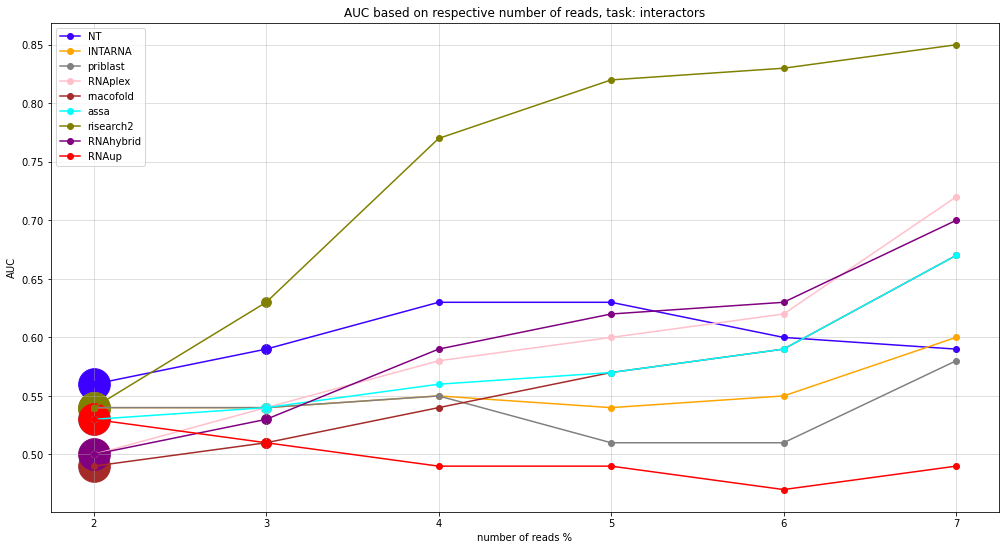




TASK:  patches


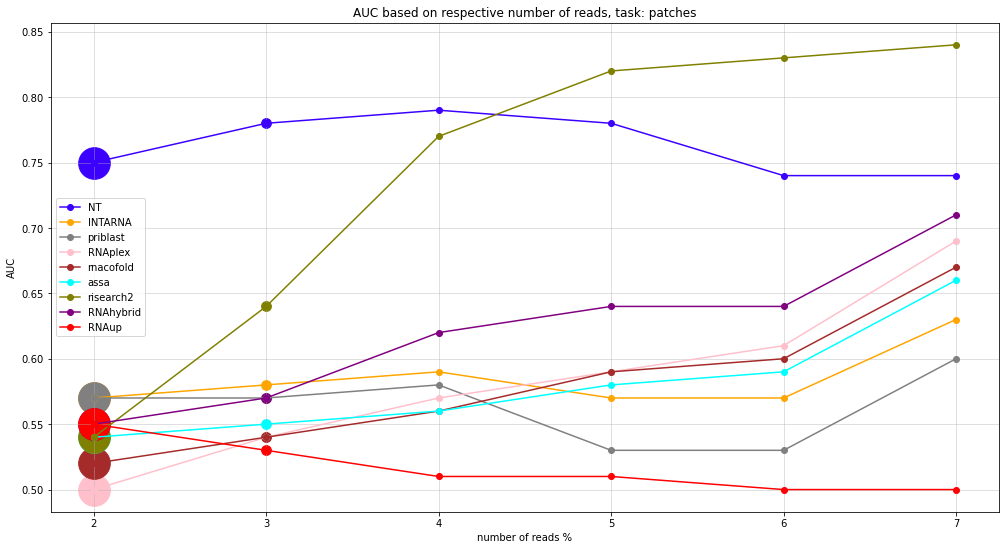

In [23]:
model_names = list(df_auc['model_name'])
size_multiplier = 10
metric = 'AUC'
string_label = 'number of reads'
figsize = (17,9)

for task_name in ['interactors', 'patches']:
    auc_models = []
    perc_models = []
    for model_name in model_names:
        auc_current_model = []
        for N_READS_RICSEQ in list_of_n_reads_ricseq:
            auc_current_model.append(df_auc[df_auc['model_name'] == model_name][f'auc_{task_name}_ricseq_nread{N_READS_RICSEQ}'].iloc[0])
        auc_models.append(auc_current_model)
        perc_models.append(np.array(n_positives_run)/np.max(n_positives_run) * 100)
        
    print('TASK: ', task_name)
    plt.figure(figsize=figsize)
    plot_metric_confidence_for_all_models(list_of_n_reads_ricseq, auc_models, perc_models, model_names, task_name, size_multiplier, metric, string_label)
    plt.show()
    print('\n\n')

### Paris AUC increase with higher interaction length size

###### Il modo in cui carico i dataset tiene conto del fatto che la regione di interazione ha senso filtrarla per lunghezza solo per i positivi e gli smartneg. Quindi per hardneg, easyneg io caricherò tutti i dati non devo filtrare per lunghezza della regione di interazione.

In [24]:
dfs = []

aucs_epsn = []
aucs_enhn500 = []
aucs_enhn = []
n_positives_run = []

list_of_paris_hq_tresholds = [15, 20, 25, 30, 35, 40, 45]

for HQ_THRESHOLD in tqdm(list_of_paris_hq_tresholds):
    
    args_copy = copy.deepcopy(args_datasets)
    args_copy['paris']['PARIS_HQ'] = True
    args_copy['paris']['PARIS_HQ_THRESHOLD'] = HQ_THRESHOLD
    
    res = load_test_set_df(external_dataset_dir, checkpoint_dir, tools, 'paris', args_copy)
    
    easypos_smartneg, ephnen, enhn500 = obtain_epsn_ephnen_from_res(res) 
    
    pos = easypos_smartneg[easypos_smartneg.policy == 'easypos'].reset_index(drop = True)
    n_positives_run.append(pos.shape[0])
    

    dfs.append(obtain_all_model_auc(easypos_smartneg, tools).rename({'auc': f'auc_interactors_paris_len{HQ_THRESHOLD}'}, axis = 1))
    dfs.append(obtain_all_model_auc_patches(res, tools).rename({'auc': f'auc_patches_paris_len{HQ_THRESHOLD}'}, axis = 1))

df_auc = pd.concat(dfs, axis = 1)
df_auc = df_auc.loc[:,~df_auc.columns.duplicated()].copy()

  0%|          | 0/7 [00:00<?, ?it/s]

TASK:  interactors


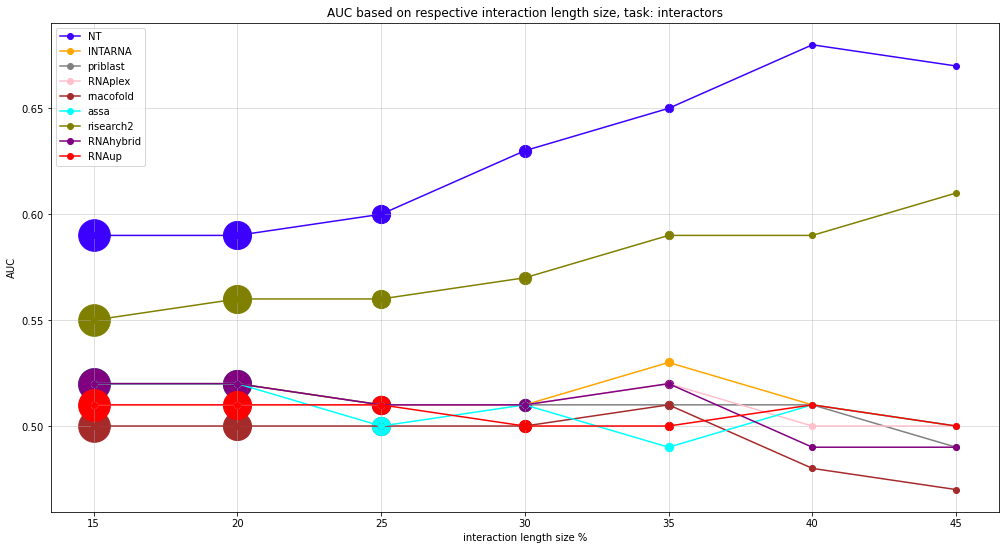




TASK:  patches


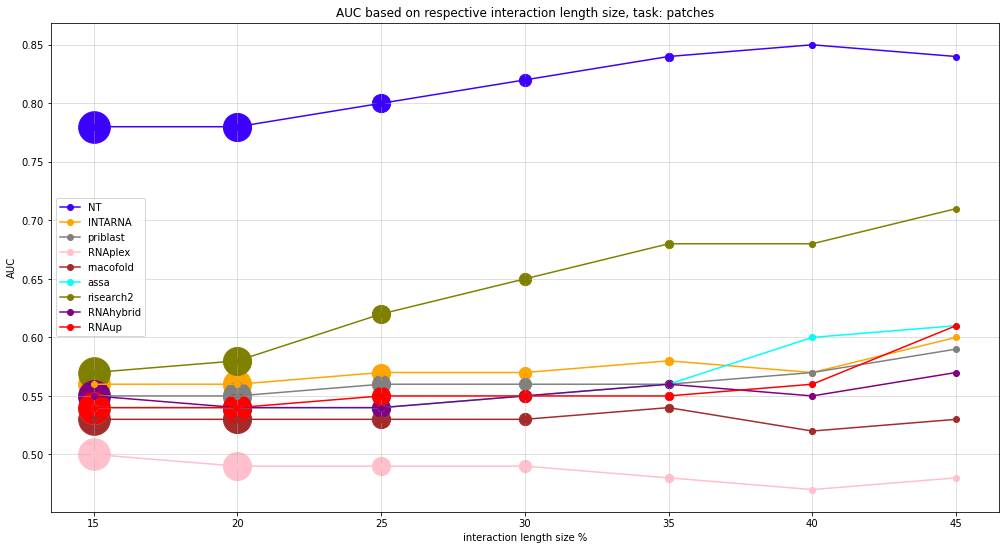

In [25]:
model_names = list(df_auc['model_name'])
size_multiplier = 10
metric = 'AUC'
string_label = 'interaction length size'
figsize = (17,9)

for task_name in ['interactors', 'patches']:
    auc_models = []
    perc_models = []
    for model_name in model_names:
        auc_current_model = []
        for HQ_THRESHOLD in list_of_paris_hq_tresholds:
            auc_current_model.append(df_auc[df_auc['model_name'] == model_name][f'auc_{task_name}_paris_len{HQ_THRESHOLD}'].iloc[0])
        auc_models.append(auc_current_model)
        perc_models.append(np.array(n_positives_run)/np.max(n_positives_run) * 100)

    print('TASK: ', task_name)
    plt.figure(figsize=figsize)
    plot_metric_confidence_for_all_models(list_of_paris_hq_tresholds, auc_models, perc_models, model_names, task_name, size_multiplier, metric, string_label)
    plt.show()
    print('\n\n')

# Quali sono le coppie di RICSEQ in cui funziona cosi bene

In [26]:
res = load_test_set_df(external_dataset_dir, checkpoint_dir, tools, 'ricseq', args_datasets)

for model_column in energy_columns:
    lrm_dict = logistic_regression_models[model_column]

    X_test = np.expand_dims(res[model_column], 1)
    y_pred = log_func(lrm_dict['intercept'], lrm_dict['coef'], X_test)
    res[model_column] = pd.Series(y_pred.flatten()) #modify column according to the model mapping
    
pos = res[res.policy == 'easypos'].reset_index(drop = True)

# excluded couples:  234


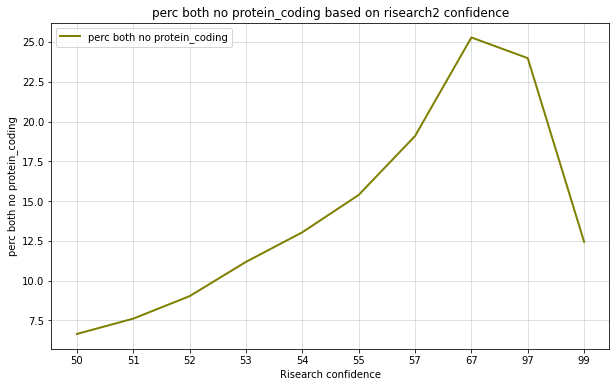

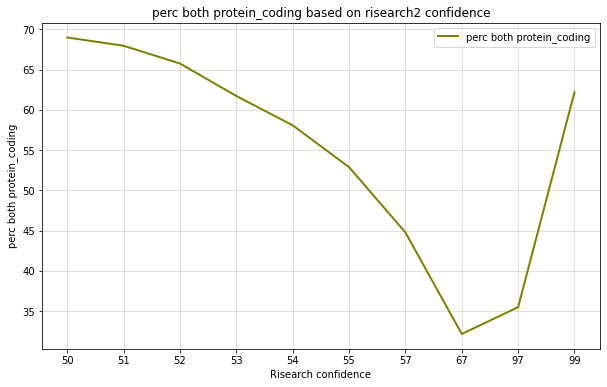

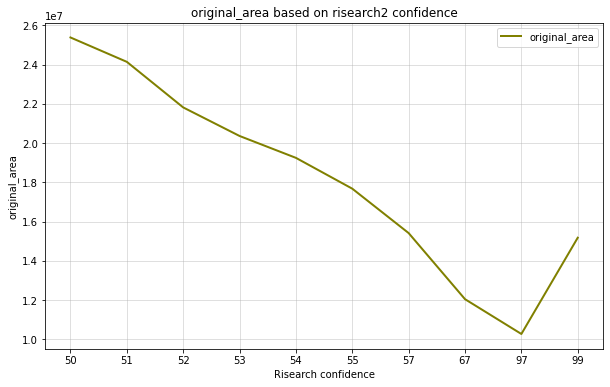

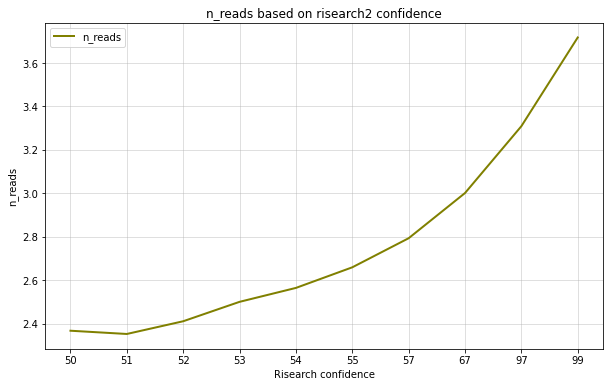

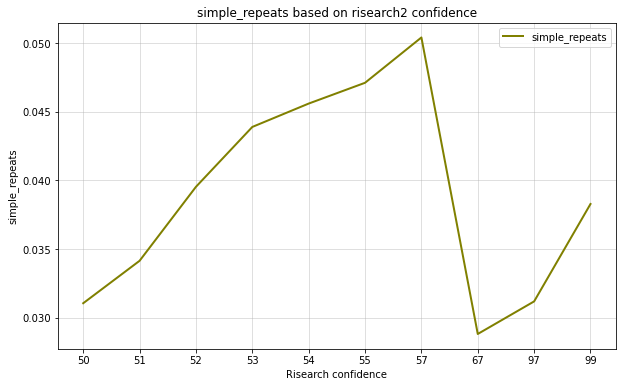

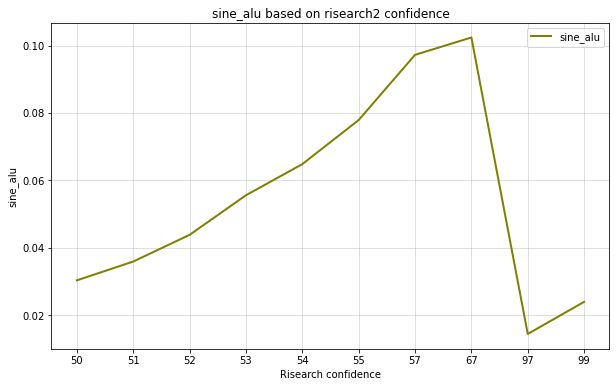

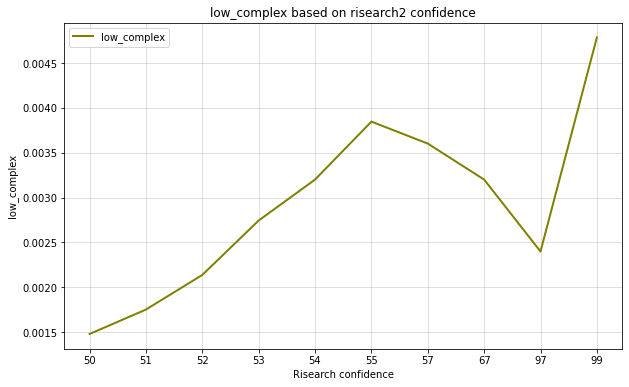

In [27]:
need_both_sr_for_satisfy_condition = True
full_overlap = False


if full_overlap:
    suffix = 'full_'
else:
    suffix = ''

pos['simple_repeat1'] = pos[f'{suffix}feature1'].apply(lambda x: 'Simple_repeat' in x)
pos['simple_repeat2'] = pos[f'{suffix}feature2'].apply(lambda x: 'Simple_repeat' in x)
pos['sine_alu1'] = pos[f'{suffix}feature1'].apply(lambda x: 'SINE' in x)
pos['sine_alu2'] = pos[f'{suffix}feature2'].apply(lambda x: 'SINE' in x)
pos['low_complex1'] = pos[f'{suffix}feature1'].apply(lambda x: 'Low_complexity' in x)
pos['low_complex2'] = pos[f'{suffix}feature2'].apply(lambda x: 'Low_complexity' in x)

if need_both_sr_for_satisfy_condition:
    pos['simple_repeats'] = pos['simple_repeat1'] & pos['simple_repeat2']
    pos['sine_alu'] = pos['sine_alu1'] & pos['sine_alu2']
    pos['low_complex'] = pos['low_complex1'] & pos['low_complex2']
else:
    pos['simple_repeats'] = pos['simple_repeat1'] | pos['simple_repeat2']
    pos['sine_alu'] = pos['sine_alu1'] | pos['sine_alu2']
    pos['low_complex'] = pos['low_complex1'] | pos['low_complex2']
    
    
    
corrected_pos = pos[pos.risearch2 > 0.5]

n_values = 15
figsize = (10, 6)
plot_features_vs_risearch2_confidence(corrected_pos, based_on_percentile = True, n_values = n_values, figsize = figsize)